# 0.0 SETUP

## 0.1 Imports

In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import pandas.io.sql as psql
import seaborn             as sns
import scikitplot as skplt
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from IPython.display       import Image
import warnings
warnings.filterwarnings( 'ignore' )

from IPython.core.display  import HTML
from scipy                 import stats     as ss
from scipy.stats           import pointbiserialr, chi2_contingency

# Rescaling Features
from sklearn.preprocessing     import MinMaxScaler, LabelEncoder

# Feature Selection
from boruta                    import BorutaPy
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import ensemble        as en

# Machine Learning
from sklearn.model_selection import train_test_split
from imblearn.combine        import SMOTETomek
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from catboost                import CatBoostClassifier
from lightgbm                import LGBMClassifier
from xgboost                 import XGBClassifier
from imblearn.ensemble       import BalancedRandomForestClassifier
from sklearn import neighbors as nh
from sklearn import linear_model as lm

# metrics
from random            import choices as rchoice
from sklearn.metrics   import accuracy_score, precision_score, recall_score
from sklearn.metrics   import roc_auc_score, f1_score, cohen_kappa_score, roc_curve
from sklearn.metrics   import precision_recall_curve, classification_report, brier_score_loss
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import pickle

# cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold 



#fine tuning
from numpy                   import argmax
from skopt                   import BayesSearchCV
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

## 0.2 Helper Functions

In [2]:
# Jupyter Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['font.size'] = 25
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def cat_info(ax,total,size,file=False):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(height/total*100),
                ha="center",size=size) 
    plt.show()

In [4]:
def descriptive_statistics (num_df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_df.apply(np.mean)).T
    ct2 = pd.DataFrame(num_df.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_df.apply(np.std)).T
    d2 = pd.DataFrame(num_df.apply(min)).T
    d3 = pd.DataFrame(num_df.apply(max)).T
    d4 = pd.DataFrame(num_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

In [5]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2/ (n - 1) 
    rcorr = r - (r - 1) ** 2/ (n - 1) 
    
    v = np.sqrt( (chi2corr / n) / (min (kcorr - 1,rcorr - 1)))
    return v   

In [6]:
def feature_selection(model, X, y):
    model.fit(X, y)
        
    # Feature importance data frame
    feat_imp = pd.DataFrame({'feature': X.columns,
                             'feature_importance': model.feature_importances_}) \
                             .sort_values('feature_importance', ascending = False) \
                             .reset_index(drop = True)
        
    # Plot feature importance
    plt.figure(figsize = (12,6))
    sns.barplot(x = 'feature_importance', y = 'feature', data = feat_imp, orient = 'h', palette = 'winter_r')
    plt.title(type (model).__name__, size = 16)
    plt.yticks(size = 13)
    plt.xticks(size = 13)
    plt.xlabel('Feature Importance', size = 16, color = 'grey')
    plt.ylabel('Features', size = 16, color = 'grey')

In [7]:
def ml_performance(models, X_train, y_train, X_valid, y_valid, threshold):
    model_df = []     
    for model in models:
        print("Training " + type(model).__name__ + "...")
        model.fit(X_train, y_train)
        
        # prediction positive probabilities according to a threshold
        y_proba = model.predict_proba(X_valid)[:, 1]
        y_hat = (y_proba >= threshold).astype(int)
        
        # metrics
        f1 = f1_score(y_valid, y_hat)
        accuracy = accuracy_score(y_valid, y_hat)
        kappa = cohen_kappa_score(y_valid, y_hat)
        roc_auc = roc_auc_score(y_valid, y_hat)
        precision = precision_score(y_valid, y_hat)
        recall = recall_score(y_valid, y_hat)
        brier = brier_score_loss(y_valid, y_hat, pos_label=1)
        
        metrics = pd.DataFrame({'Model Name': type(model).__name__,'Accuracy': accuracy,'Precision': precision,
                                'Recall': recall,'F1-Score': f1,'ROC-AUC': roc_auc,'Kappa': kappa,
                                'Brier': brier}, index = [0]).sort_values('F1-Score', ascending = False)
        
        model_df.append(metrics)
        final_model = pd.concat(model_df)
    return final_model.sort_values('F1-Score', ascending = False).round(5)

In [8]:
def cross_validation(models, X, y, cv,n_jobs= -1):
    cv_df = []
    for n in models:
        accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
        accuracy = "{:.4f} +/- %{:.4f}".format(accuracy_cv.mean(), accuracy_cv.std())
        prec_cv = cross_val_score(n, X, y, cv = cv, scoring='precision', n_jobs=-1)
        prec = "{:.4f} +/- %{:.4f}".format(prec_cv.mean(), prec_cv.std())
        recall_cv = cross_val_score(n, X, y, cv = cv, scoring='recall', n_jobs=-1)
        recall = "{:.4f} +/- %{:.4f}".format(recall_cv.mean(), recall_cv.std())
        f1_score_cv = cross_val_score(n, X, y, cv = cv, scoring='f1', n_jobs=-1)
        f1_score = "{:.4f} +/- %{:.4f}".format(f1_score_cv.mean(), f1_score_cv.std())
        roc_auc_cv = cross_val_score(n, X, y, cv = cv, scoring='roc_auc', n_jobs=-1)
        roc_auc = "{:.4f} +/- %{:.4f}".format(roc_auc_cv.mean(), roc_auc_cv.std())
        
                
        A = pd.DataFrame( {'Model Name': type(n).__name__,
                           'Accuracy (Avg+Std)': accuracy,
                           'Precision (Avg+Std) ': prec,
                           'Recall (Avg+Std) ': recall,
                           'F1-Score (Avg+Std)': f1_score,
                           'ROC-AUC (Avg+Std)': roc_auc }, index = [0])
    
        cv_df.append(A)
        final_dfa = pd.concat(cv_df)


In [9]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop= True)

    # Create Ranking order
    data['ranking'] = data.index+1

    data['recall_at_k'] = data['response'].cumsum()/ data['response'].sum()

    return data.loc[k,'recall_at_k']

In [10]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop= True)

    # Create Ranking order
    data['ranking'] = data.index+1

    data['precision_at_k'] = data['response'].cumsum()/ data['ranking']

    return data.loc[k,'precision_at_k']

## 0.3 Loading Data

In [11]:
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = '5432'
# database = 'comunidadedsdb'
# username = 'member'
# password = 'cdspa'

### 0.3.1 Schema Query

In [12]:
# try:
#     conn = pg.connect("dbname=comunidadedsdb user=member password=cdspa host=comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com port=5432")

# except:
#     print ("Unable to connect to the database.")
    
# cursor = conn.cursor()
# query_schema = "SELECT nspname FROM pg_catalog.pg_namespace"

# try:
#     cursor.execute(query_schema)

# except:
#     print ("Can't drop our test database!")

# record = cursor.fetchall()
# print(record)

# cursor.close()
# conn.close()

### 0.3.2 Table Query

In [13]:
# try:
#     conn = pg.connect("dbname=comunidadedsdb user=member password=cdspa host=comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com port=5432")

# except:
#     print ("Unable to connect to the database.")
    
# cursor = conn.cursor()
# query_tables = "SELECT tablename FROM pg_tables WHERE schemaname='pa004'"

# try:
#     cursor.execute(query_tables)

# except:
#     print ("Can't drop our test database!")

# record = cursor.fetchall()
# print(record)

# cursor.close()
# conn.close()

### 0.3.3 Collect Data

In [14]:
# conn = pg.connect("dbname=comunidadedsdb user=member password=cdspa host=comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com port=5432")

# query_all_tables = """
#                   SELECT U.id, U.gender, U.age, U.region_code, U.policy_sales_channel, 
#                              I.previously_insured, I.annual_premium, I.vintage,
#                              V.driving_license, V.vehicle_age, V.vehicle_damage,
#                              I.response
#                   FROM pa004.users U LEFT JOIN pa004.insurance I ON U.id = I.id
#                                      LEFT JOIN pa004.vehicle   V ON U.id = V.id"""

In [15]:
# df_raw = pd.read_sql( query_all_tables, conn )
# conn.close()

In [16]:
#df_raw.to_csv('clients.csv', index=False)

# 1.0 DATA DESCRIPTION

In [17]:
df1 = pd.read_csv('clients.csv')

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   annual_premium        381109 non-null  float64
 7   vintage               381109 non-null  int64  
 8   driving_license       381109 non-null  int64  
 9   vehicle_age           381109 non-null  object 
 10  vehicle_damage        381109 non-null  object 
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [19]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,Male,23,11.00000,152.00000,0,23367.00000,249,1,< 1 Year,Yes,0
1,13,Female,41,15.00000,14.00000,1,31409.00000,221,1,1-2 Year,No,0
2,18,Female,25,35.00000,152.00000,1,46622.00000,299,1,< 1 Year,No,0
3,31,Female,26,8.00000,160.00000,0,2630.00000,136,1,< 1 Year,No,0
4,39,Male,45,8.00000,124.00000,0,42297.00000,264,1,1-2 Year,Yes,0


## 1.1 Features Description


The data set includes the following information:

**Id:** customer's unique identifier.

**Gender:** gender of the client.

**Age:** age of the customer.

**Driving License:** 0, the customer is not allowed to drive and 1, the customer is allowed to drive (CNH - National Driver's License).

**Region Code:** code of the customer's region.

**Previously Insured:** 0, the customer does not have auto insurance and 1, the customer already has auto insurance.

**Vehicle Age:** age of the vehicle.

**Vehicle Damage:** 0, customer has never had his vehicle damaged in the past and 1, customer has had his vehicle damaged in the past.

**Annual Premium:** amount the customer paid the company for annual health insurance.

**Policy sales channel:** anonymous code for the customer contact channel.

**Vintage:** number of days the customer joined the company through the purchase of health insurance.

**Response:** 0, the customer is not interested and 1, the customer is interested.

## 1.2 Data Dimentions

In [20]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of cols: 12


## 1.3 Data Types

In [21]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

## 1.4 Check NA

In [22]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

## 1.5 Change Types

In [23]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['annual_premium'] = df1['annual_premium'].astype(int)
df1['region_code'] = df1['region_code'].astype(int)

# Vehicle damage
df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

In [24]:
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
previously_insured       int64
annual_premium           int64
vintage                  int64
driving_license          int64
vehicle_age             object
vehicle_damage           int64
response                 int64
dtype: object

## 1.6 Descriptive Statistical

In [25]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32'])

### 1.6.1 Numerical Attributes

In [26]:
descriptive_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00000,381109.00000,381108.00000,190555.00000,190555.00000,110016.69187,-0.00000,-1.20000
1,age,20.00000,85.00000,65.00000,38.82258,36.00000,15.51159,0.67254,-0.56566
2,region_code,0.00000,52.00000,52.00000,26.38881,28.00000,13.22987,-0.11527,-0.86786
3,policy_sales_channel,1.00000,163.00000,162.00000,112.03429,133.00000,54.20392,-0.90001,-0.97081
4,previously_insured,0.00000,1.00000,1.00000,0.45821,0.00000,0.49825,0.16775,-1.97187
5,annual_premium,2630.00000,540165.00000,537535.00000,30564.38958,31669.00000,17213.13247,1.76609,34.00457
6,vintage,10.00000,299.00000,289.00000,154.34740,154.00000,83.67119,0.00303,-1.20069
7,driving_license,0.00000,1.00000,1.00000,0.99787,1.00000,0.04611,-21.59518,464.35430
8,vehicle_damage,0.00000,1.00000,1.00000,0.50488,1.00000,0.49998,-0.01951,-1.99963
9,response,0.00000,1.00000,1.00000,0.12256,0.00000,0.32794,2.30191,3.29879


### 1.6.2 Categorical Attributes

In [27]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender         2
vehicle_age    3
dtype: int64

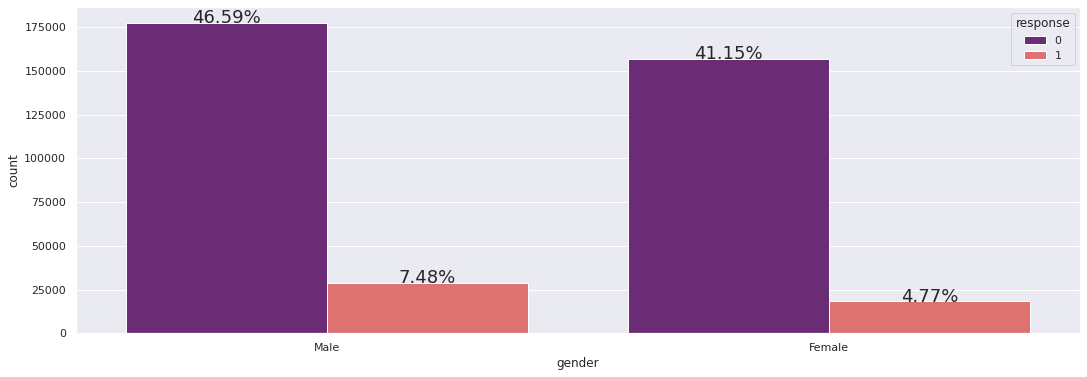

In [28]:
plt.figure(figsize = (18, 6))

ax = sns.countplot(x = 'gender',hue='response', data = df1, palette = "magma" )
cat_info(ax,df1['response'].shape[0],18);


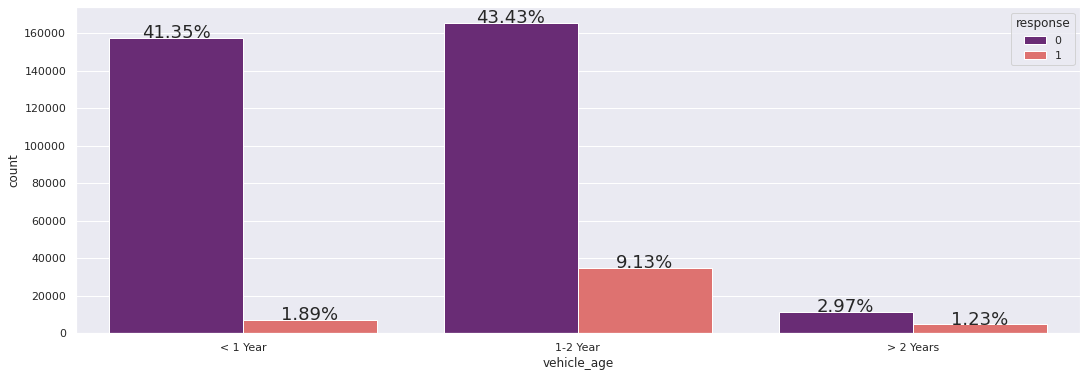

In [29]:
plt.figure(figsize = (18, 6))

ax = sns.countplot(x = 'vehicle_age',hue='response', data = df1, palette = "magma" )
cat_info(ax,df1['response'].shape[0],18);


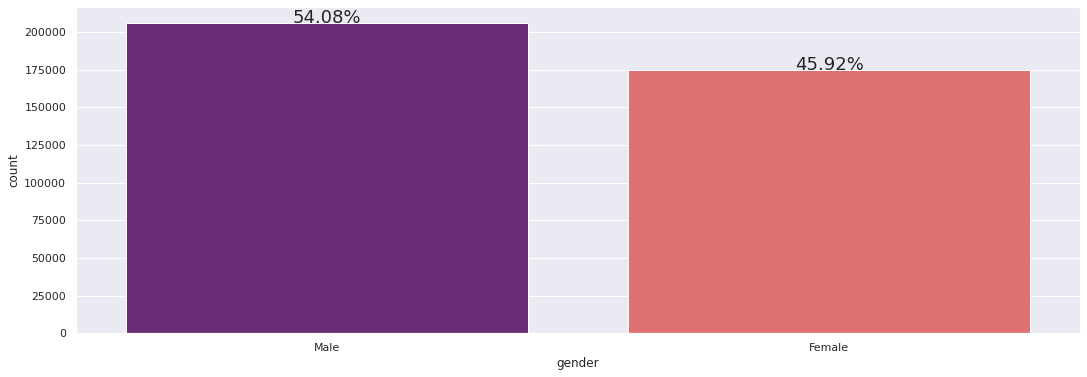

In [30]:
plt.figure(figsize = (18, 6))

ax = sns.countplot(x = 'gender', data = df1, palette = "magma" )

cat_info(ax,df1['response'].shape[0],18);


# 2.0 FEATURE ENGENEERING

In [31]:
df2 = df1.copy()

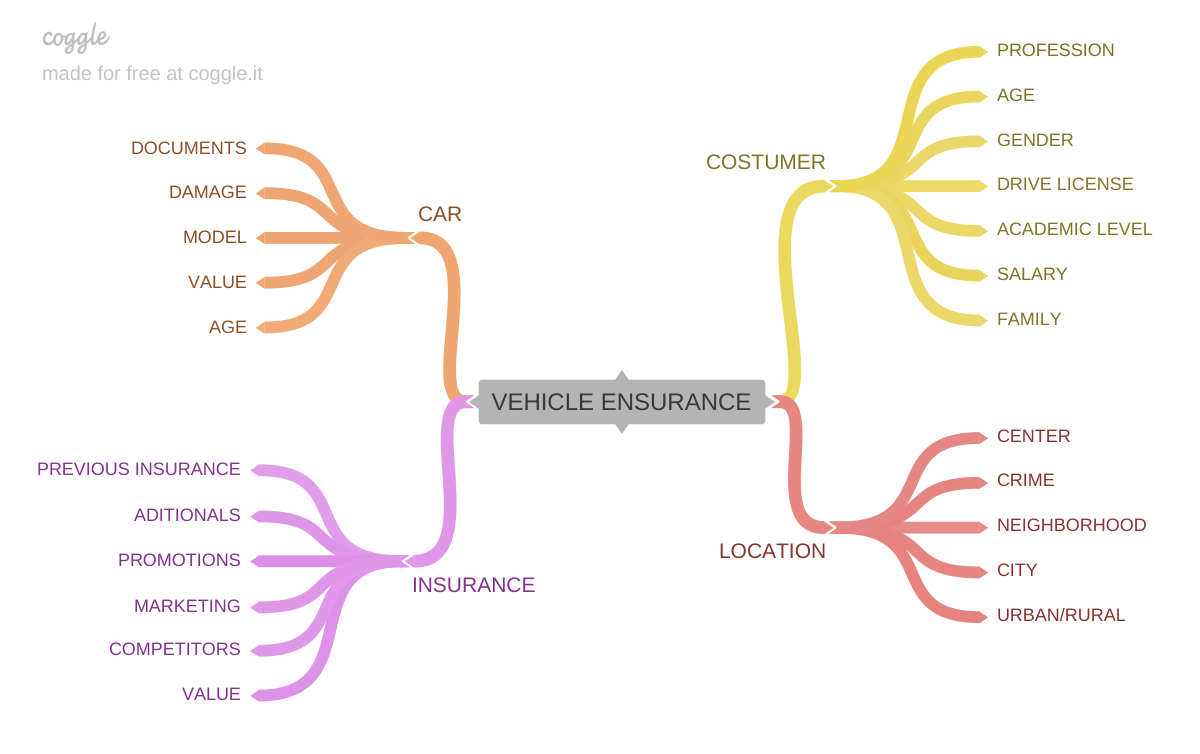

In [32]:
Image ('img/VEHICLE_ENSURANCE.png')

## 2.2 Hypotheses criation

### 2.2.1 Hypotheses Costumer

**1.** Customers with high-paying jobs should want more a motor ensurance.

**2.** Older customers should want more a motor ensurance.

**3.** Female customers should want more a motor ensurance.

**4.** Customers without drive license shouldn't want a motor ensurance.

**5.** Customers with high academy level should want more a motor ensurance.

**6.** Customers with family should want more a motor ensurance.

**7.** Customers with high number of children should want more a motor ensurance.

**8.** Customers with high Annual Premium should want more a motor ensurance.

### 2.2.2 Hypotheses Location

**1.** Customers that lives on city centers should want more a motor ensurance.

**2.** Customers living in a violent region should want more a motor ensurance.

**3.** Customers living in a poor neighborhood should want more a motor ensurance.

**4.** Customers living in big cities should want more a motor ensurance.

**5.** Customers living in the countryside shouldn't want a motor ensurance.

**6.** Customers who live in regions with more demage rate should want auto insurance.

### 2.2.3 Hypotheses Car

**1.** Customers with cars without documents shouldn't want a motor ensurance.

**2.** Customers that had previous acidents should want more a motor ensurance.

**3.** Customers who own a more expensive car model should want more a motor ensurance.

**4.** ustomers who own a more stolen car model should want more car insurance.

**5.** Customers who own a more expensive car should want more motor insurance.

**6.** Customers who own a newer car should want more auto insurance.

### 2.2.4 Hypotheses Insurance

**1.** Customers that had a previous auto ensurance should want more a motor ensurance.

**2.** Motor insurance with additional offers should sell more.

**3.** Motor insurance in promotions offers should sell more.

**4.** Motor insurance with a good marketing should sell more.

**5.** Motor insurance with less competitors should sell more.

**6.** Motor insurance with lower values should sell more.

**7.** Customers who use life insurance more, should want auto insurance

## 2.3 Hypotheses final list

**1.** Older customers should want more a motor ensurance.

**2.** Female customers should want more a motor ensurance.

**3.** Customers without drive license shouldn't want a motor ensurance.

**4.** Customers with high Annual Premium should want more a motor ensurance.

**5.** Customers that lives on city centers should want more a motor ensurance.

**6.** Customers that had previous acidents should want more a motor ensurance.

**7.** Customers who own a newer car should want more auto insurance.

**8.** Customers that had a previous auto ensurance should want more a motor ensurance.

**9.** Customers who use life insurance more, should want auto insurance.

**10.** Customers who live in regions with more demage rate should want auto insurance.

## 2.4 Hypotheses for Future Analysis

**1.** Customers with high-paying jobs should want more a motor ensurance.

**2.** Customers with high academy level should want more a motor ensurance.

**3.** Customers with family should want more a motor ensurance.

**4.** Customers with high number of children should want more a motor ensurance.

**5.** Customers living in a violent region should want more a motor ensurance.

**6.** Customers living in a poor neighborhood should want more a motor ensurance.

**7.** Customers living in big cities should want more a motor ensurance.

**8.** Customers living in the countryside shouldn't want a motor ensurance.

**9.** Customers with cars without documents shouldn't want a motor ensurance.

**10.** Customers who own a more expensive car model should want more a motor ensurance.

**11.** ustomers who own a more stolen car model should want more car insurance.

**12.** Customers who own a more expensive car should want more motor insurance.

**13.** Motor insurance with additional offers should sell more.

**14.** Motor insurance in promotions offers should sell more.

**15.** Motor insurance with a good marketing should sell more.

**16.** Motor insurance with less competitors should sell more.

**17.** Motor insurance with lower values should sell more.

## 2.5 Feature Engineering

In [33]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,Male,23,11,152,0,23367,249,1,< 1 Year,1,0
1,13,Female,41,15,14,1,31409,221,1,1-2 Year,0,0
2,18,Female,25,35,152,1,46622,299,1,< 1 Year,0,0
3,31,Female,26,8,160,0,2630,136,1,< 1 Year,0,0
4,39,Male,45,8,124,0,42297,264,1,1-2 Year,1,0


In [34]:
# Creating Damage por region code index
damage_per_rcode = df2[['vehicle_damage']].groupby(df2['region_code']).mean().reset_index()
damage_per_rcode = damage_per_rcode.rename( columns = {'vehicle_damage' : 'damage_per_rcode'})
df2 = df2.merge(damage_per_rcode, on = 'region_code', how = 'left')
df2['damage_per_rcode'] = df2['damage_per_rcode'].astype(np.float64)

# 3.0 VARIABLE FILTERING

In [35]:
df3 = df2.copy()

# 4.0 EXPLORATORY DATA ANALYSIS

In [36]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Gender

### 4.1.2 Age

<AxesSubplot:xlabel='response', ylabel='age'>

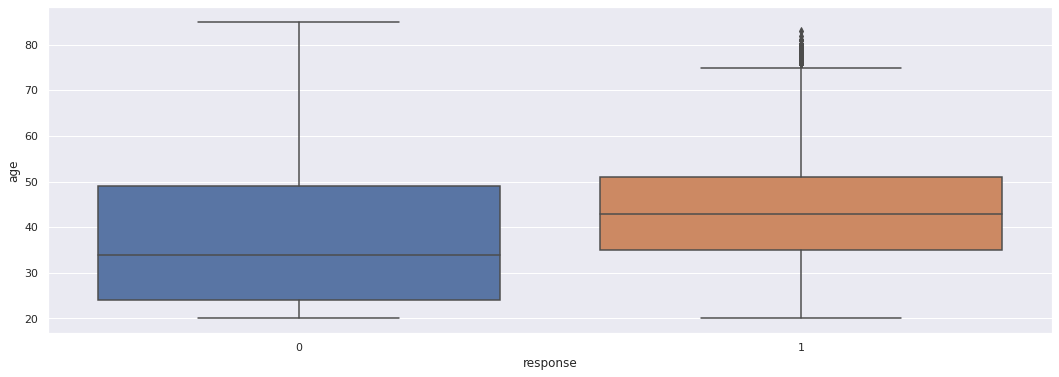

In [37]:
plt.figure(figsize = (18, 6))

#age
sns.boxplot( x= 'response',y= 'age', data= df4)

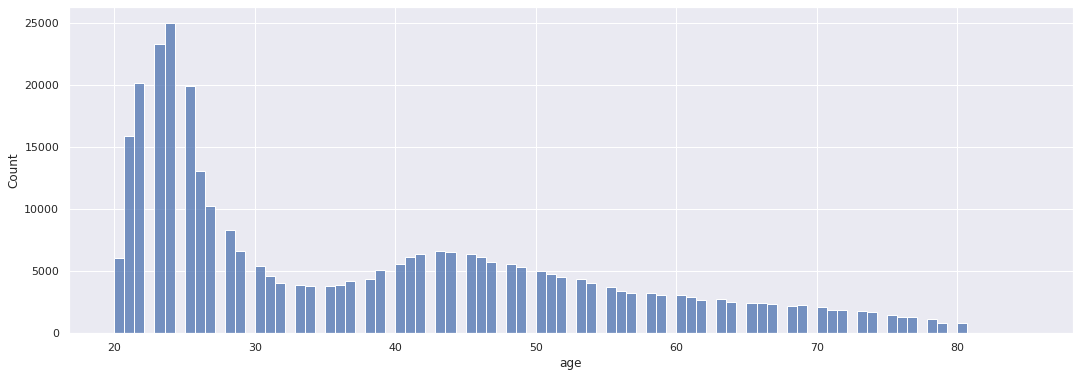

In [38]:
plt.figure(figsize = (18, 6))

aux00= df4.loc[df4['response']== 0, 'age']

sns.histplot( aux00 );

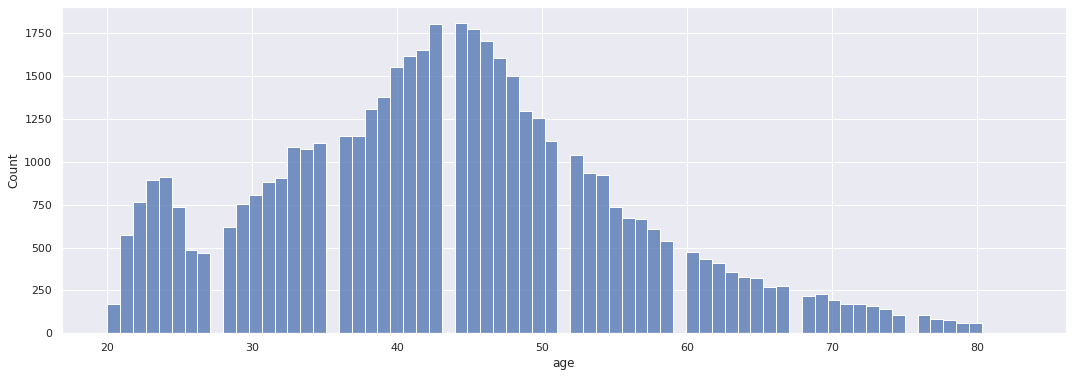

In [39]:
plt.figure(figsize = (18, 6))

aux00= df4.loc[df4['response']== 1, 'age']

sns.histplot( aux00 );

### 4.1.3 Region_code

<AxesSubplot:xlabel='region_code', ylabel='id'>

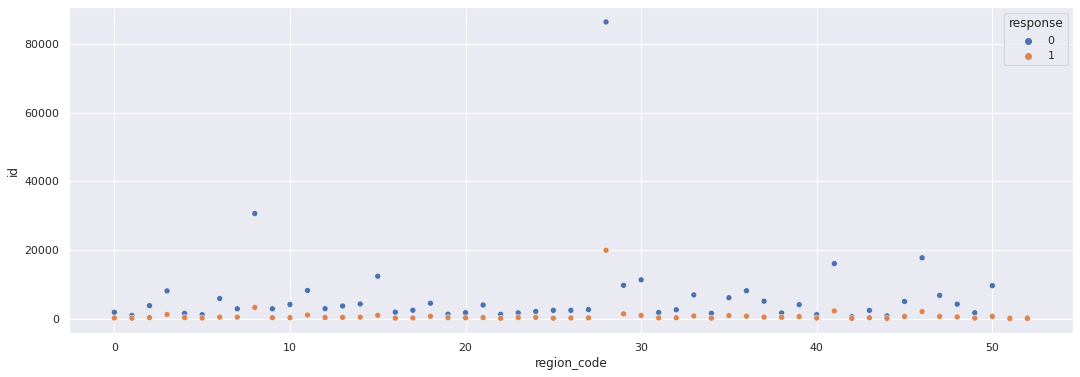

In [40]:
plt.figure(figsize = (18, 6))

aux = df4[['id','region_code','response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot( x= 'region_code', y= 'id',hue='response',data =aux)

### 4.1.4 previously_insured
       

In [41]:
pd.crosstab( df4['previously_insured'], df4['response']).apply( lambda x: x/x.sum() ,axis=1)

response,0,1
previously_insured,,
0,0.77455,0.22545
1,0.99910,0.00090


### 4.1.5 Annual premium 

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

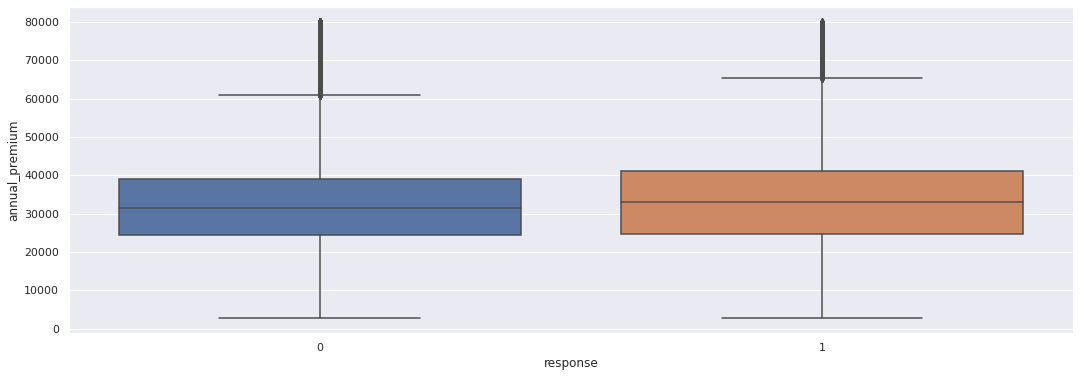

In [42]:
plt.figure(figsize = (18, 6))


aux = df4[df4['annual_premium'] < 80000]
#age
sns.boxplot( x= 'response',y= 'annual_premium', data= aux)

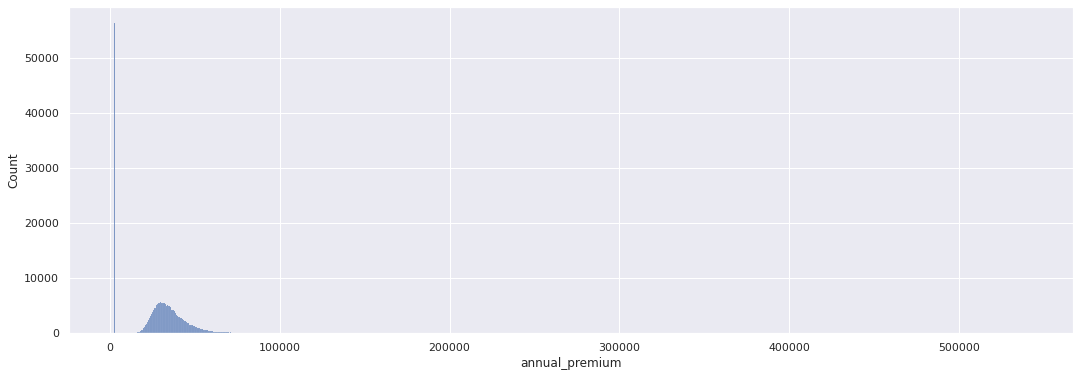

In [43]:
plt.figure(figsize = (18, 6))


aux = df4[df4['annual_premium']> 10000 &(df4['annual_premium'] < 80000)]
aux00= aux.loc[aux['response']== 0, 'annual_premium']

sns.histplot( aux00 );

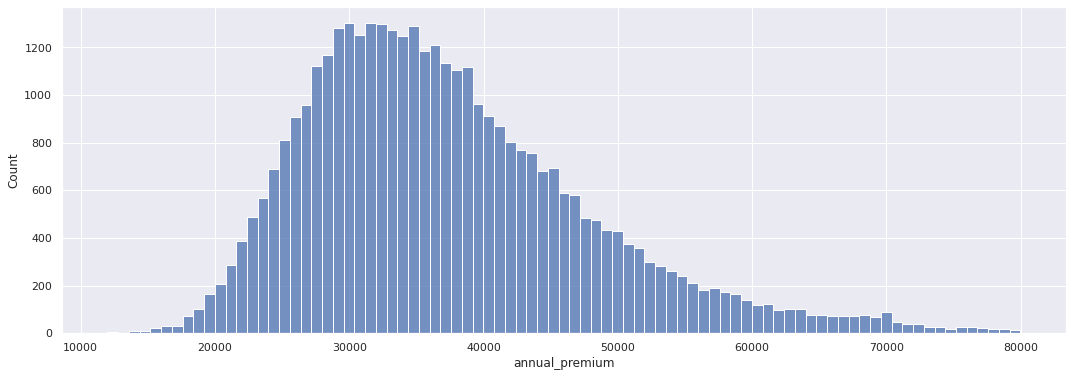

In [44]:
plt.figure(figsize = (18, 6))


aux = df4[(df4['annual_premium']> 10000) &(df4['annual_premium'] < 80000)]
aux00= aux.loc[aux['response']== 1, 'annual_premium']

sns.histplot( aux00 );

### 4.1.6 Vintage 

<AxesSubplot:xlabel='response', ylabel='vintage'>

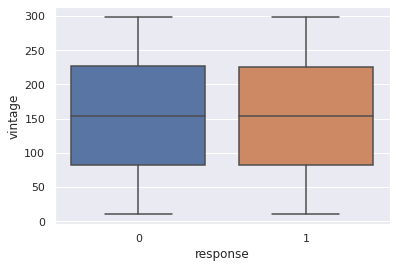

In [45]:
sns.boxplot( x= 'response', y='vintage',data= df4)

In [46]:
df4.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response,damage_per_rcode
0,7,Male,23,11,152,0,23367,249,1,< 1 Year,1,0,0.35778
1,13,Female,41,15,14,1,31409,221,1,1-2 Year,0,0,0.43816
2,18,Female,25,35,152,1,46622,299,1,< 1 Year,0,0,0.42538
3,31,Female,26,8,160,0,2630,136,1,< 1 Year,0,0,0.45860
4,39,Male,45,8,124,0,42297,264,1,1-2 Year,1,0,0.45860


### 4.1.7 Driving license

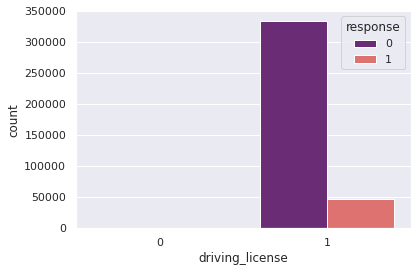

In [47]:
sns.countplot(x= 'driving_license',hue='response' ,data = df4, palette = "magma" )

cat_info(ax,len(df4),18);

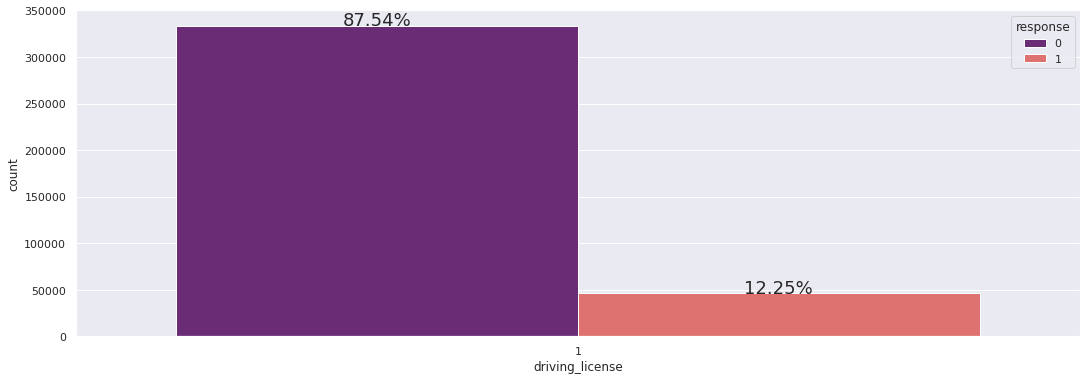

In [48]:
plt.figure(figsize = (18, 6))
aux = df4[df4['driving_license']==1]
ax = sns.countplot(x= 'driving_license',hue='response' ,data = aux, palette = "magma" )

cat_info(ax,df1['response'].shape[0],18);

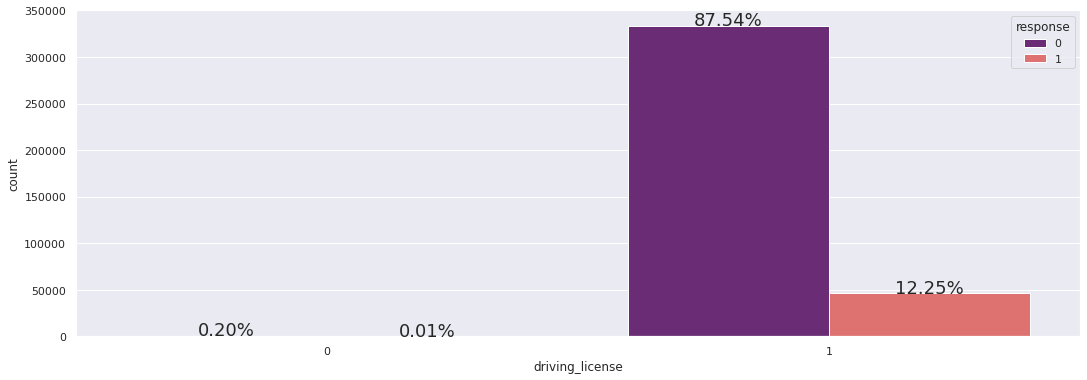

In [49]:
plt.figure(figsize = (18, 6))

ax = sns.countplot(x= 'driving_license',hue='response' ,data = df4, palette = "magma" )

cat_info(ax,df1['response'].shape[0],18);

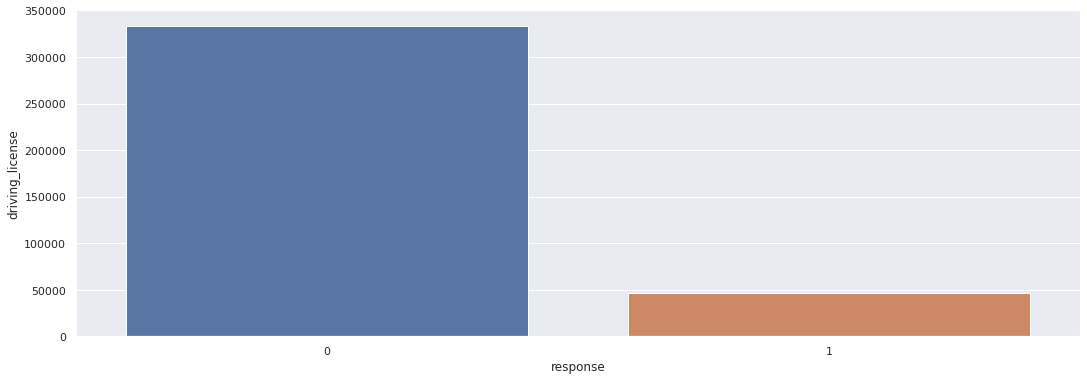

In [50]:
plt.figure(figsize = (18, 6))

aux = df4[['driving_license', 'response']].groupby( 'response').sum().reset_index()
sns.barplot(x='response',y = 'driving_license', data= aux);


In [51]:
aux['driving_license_perc'] = aux['driving_license']/aux['driving_license'].sum() 
aux

,response,driving_license,driving_license_perc
0,0,333628,0.87728
1,1,46669,0.12272


### 4.1.8 Vehicle age
       

In [52]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.43429
1,< 1 Year,0,0.41349
2,1-2 Year,1,0.09133
3,> 2 Years,0,0.02966
4,< 1 Year,1,0.01890
5,> 2 Years,1,0.01234


### 4.1.9 Vehicle damage

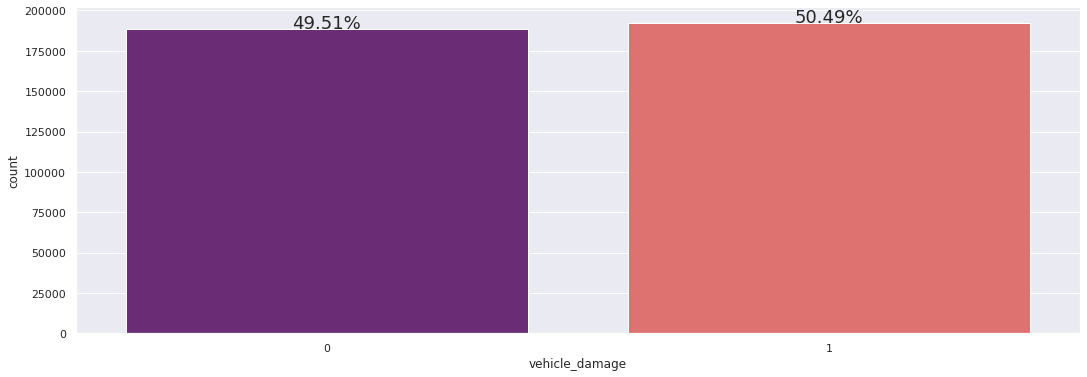

In [53]:
plt.figure(figsize = (18, 6))

ax = sns.countplot(x = 'vehicle_damage', data = df4, palette = "magma" )

cat_info(ax,df1['response'].shape[0],18);

### 4.1.10 Response

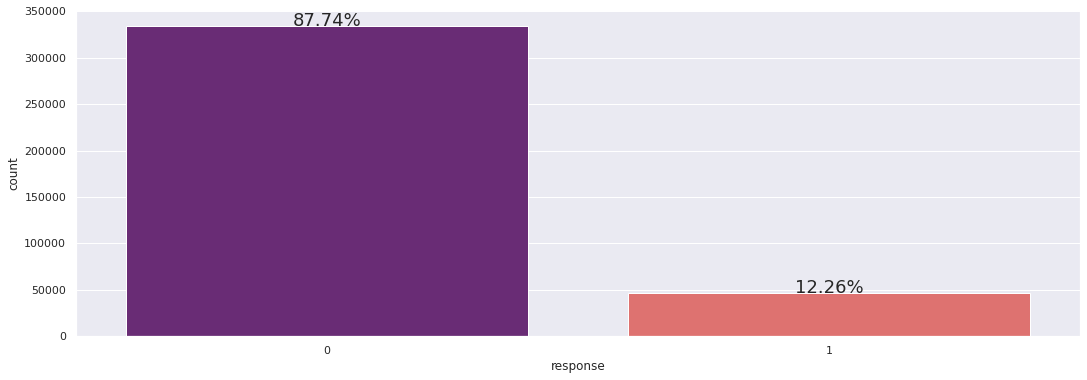

In [54]:
plt.figure(figsize = (18, 6))

ax = sns.countplot(x = 'response', data = df4, palette = "magma" )

cat_info(ax,df1['response'].shape[0],18);

### 4.1.11 Damage per rcode

### 4.1.1 Response Variable

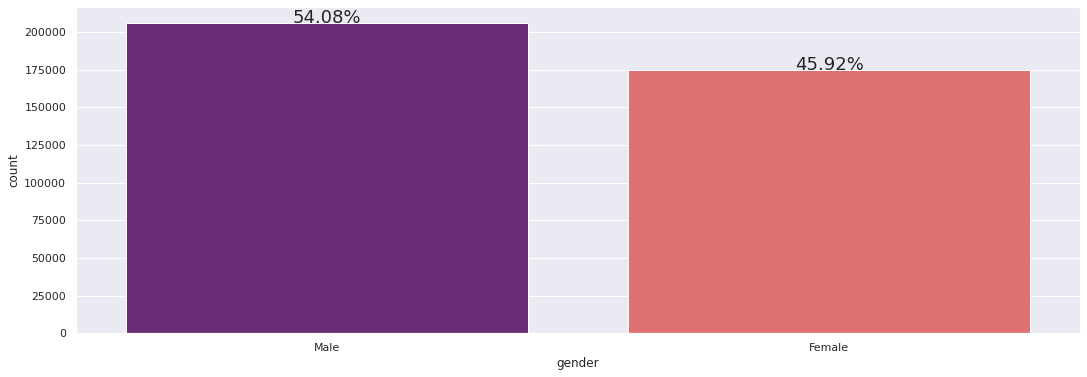

In [55]:
plt.figure(figsize = (18, 6))

ax = sns.countplot(x = 'gender', data = df4, palette = "magma" )

cat_info(ax,df1['response'].shape[0],18);

### 4.1.2 Numerical Variable

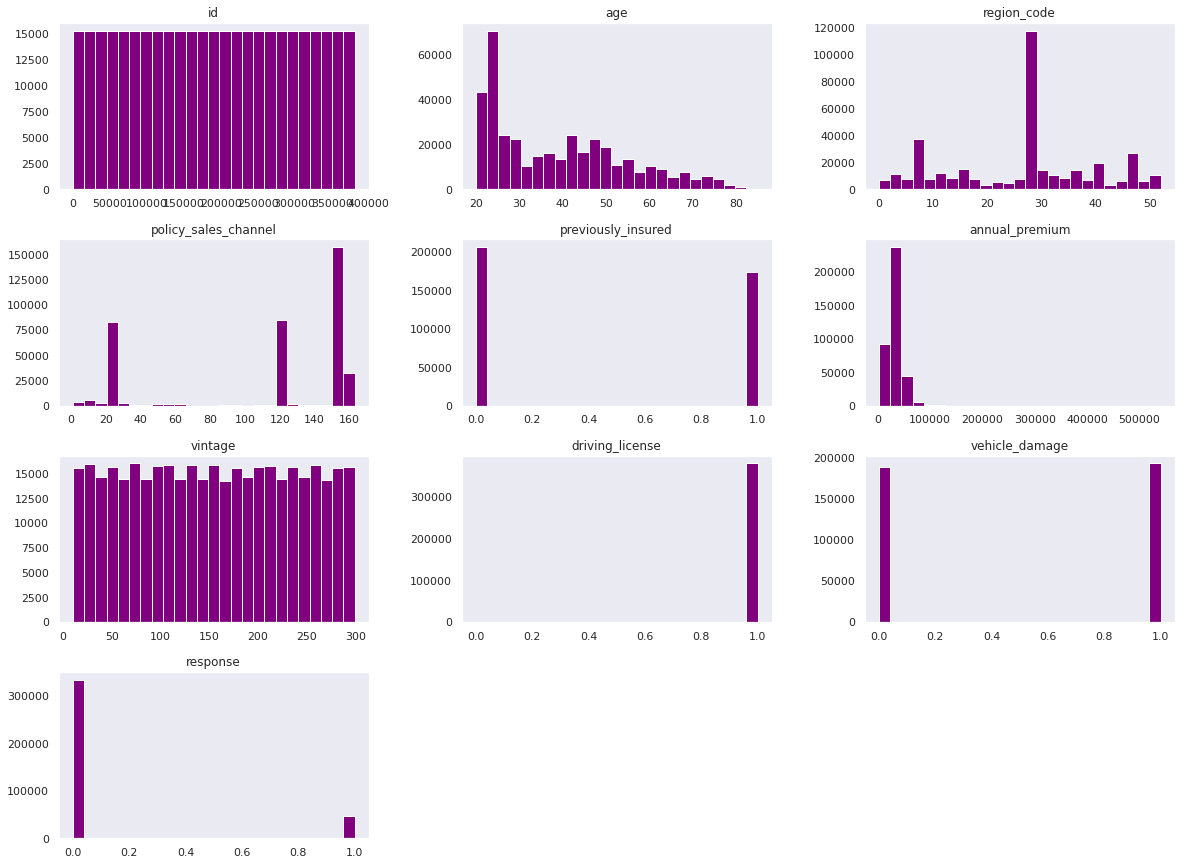

In [56]:
fig = plt.figure(figsize = (20,15))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False, color = 'purple');

### 4.1.3 Categorical Variable

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

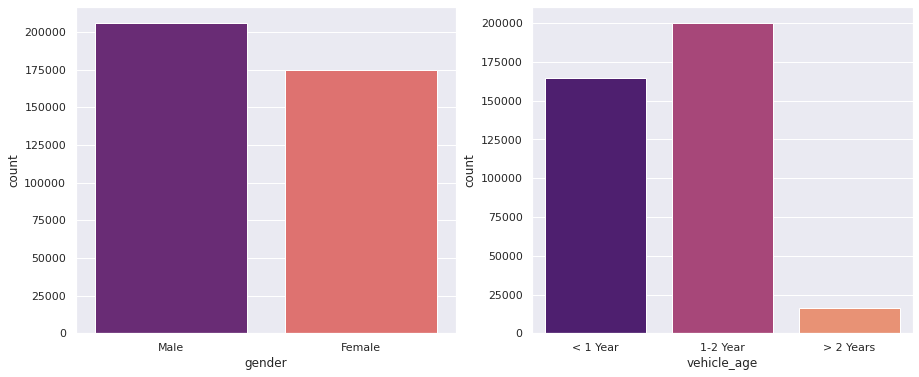

In [57]:
fig = plt.figure(figsize = (15,6))

# gender
plt.subplot (1,2,1)
sns.countplot(df4['gender'], palette = "magma")

# vehicle_age
plt.subplot (1,2,2)
sns.countplot(df4['vehicle_age'], palette = "magma")

## 4.2 Bivariate Analysis

### H1: Older customers should want more a motor ensurance.
**FALSE.** Customers with ages between 30 and 50 years old want more motor ensurance. 

<AxesSubplot:>

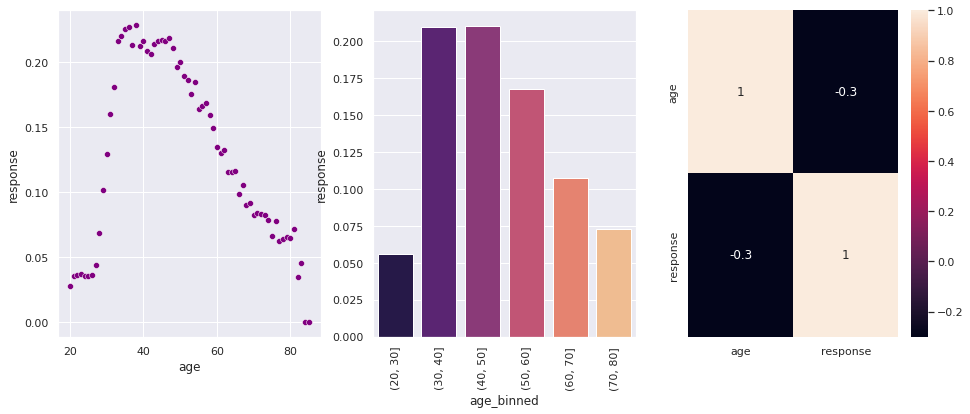

In [58]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,3,1)
aux1 = df4[['age', 'response']].groupby ('age').mean().reset_index()
sns.scatterplot(x = 'age', y = 'response', data = aux1, color = 'purple')

plt.subplot (1,3,2)
bins = list(np.arange(20, 90, 10))
aux1['age_binned'] = pd.cut (aux1['age'], bins = bins)
aux2 = aux1[['age_binned', 'response']].groupby ('age_binned').mean().reset_index()
sns.barplot(x = 'age_binned', y = 'response', data = aux2, palette = "magma")
plt.xticks(rotation = 90);

plt.subplot (1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

### H2: Female customers should want more a motor ensurance.
**FALSE.** Males want more motor ensurance then females.

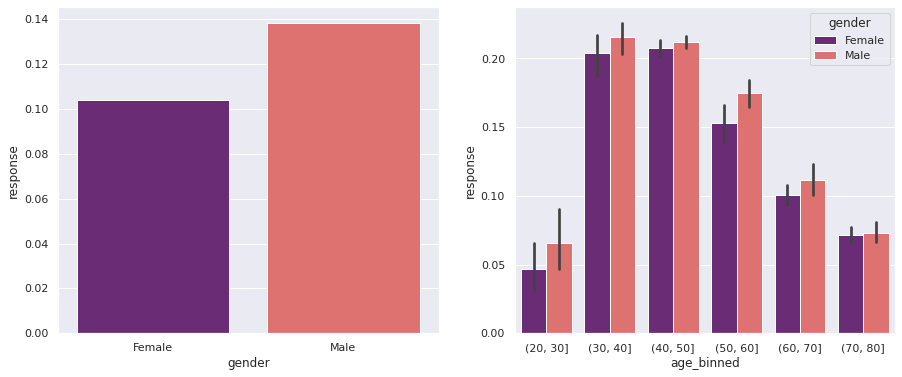

In [59]:
fig = plt.figure(figsize = (15,6))

plt.subplot (1,2,1)
aux1 = df4[['gender', 'response']].groupby('gender').mean().reset_index()
sns.barplot (x = 'gender', y = 'response', data = aux1, palette = "magma")


plt.subplot (1,2,2)
aux2 = df4[['gender', 'age', 'response']].groupby(['age', 'gender']).mean().reset_index()
bins = list(np.arange(20, 90, 10))
aux2['age_binned'] = pd.cut (aux2['age'], bins = bins)
aux3 = aux2[['gender','age_binned', 'response']].groupby ('gender').mean().reset_index()
#aux2 = df4[['age','gender', 'response']].groupby (['age', 'gender']).mean().reset_index()
sns.barplot(x = 'age_binned', y = 'response', hue = 'gender', data = aux2, palette = "magma");

### H3: Customers without drive license shouldn't want a motor ensurance.
**TRUE.** Customers with drive license want more motor ensurance.

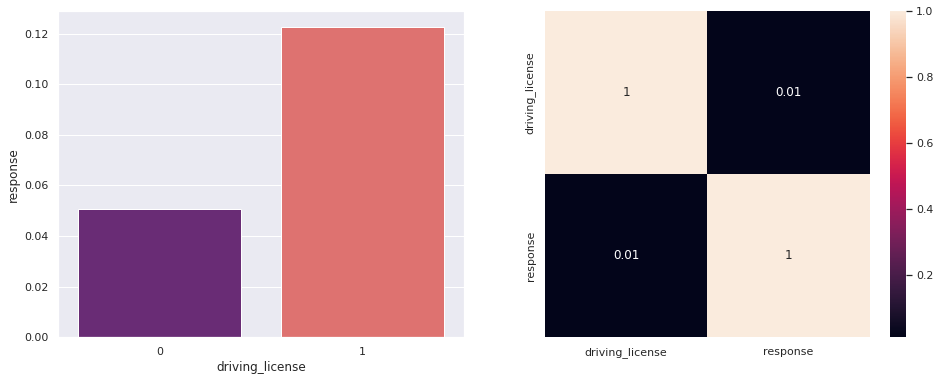

In [60]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
aux1 = df4[['driving_license', 'response']].groupby('driving_license').mean().reset_index()
sns.barplot (x = 'driving_license', y = 'response', data = aux1, palette = "magma");

plt.subplot (1,2,2)
aux2 = df4[['driving_license', 'response']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True);

### H4: Customers with high Annual Premium should want more a motor ensurance.
**TRUE.** Customers with high Annual Premium want more a motor ensurance.

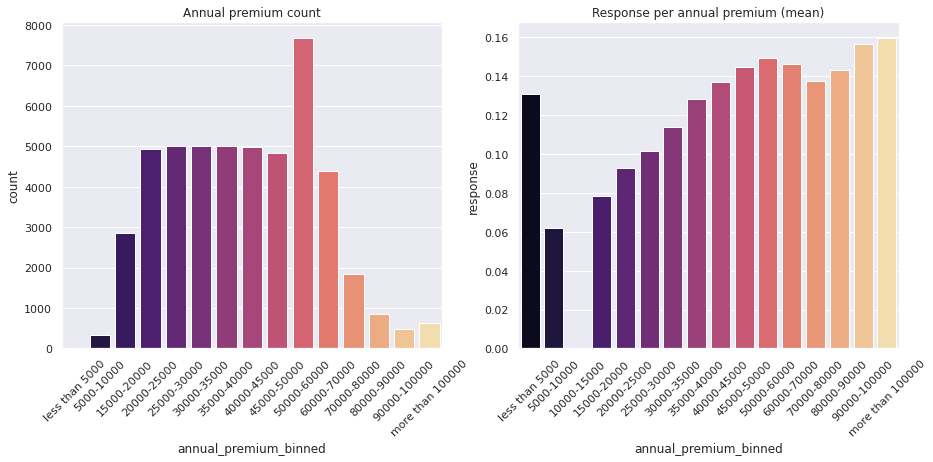

In [61]:
fig = plt.figure(figsize = (15,6))




aux2 = df4[['annual_premium', 'response']].groupby(['annual_premium']).mean().reset_index()
aux2['annual_premium_binned'] = aux2['annual_premium'].apply( lambda x: 'less than 5000' if x < 5000 
                                                              else '5000-10000' if 5000 <= x < 15000 
                                                              else '10000-15000' if 10000 <= x < 15000 
                                                              else '15000-20000' if 15000 <= x < 20000 
                                                              else '20000-25000' if 20000 <= x < 25000 
                                                              else '25000-30000' if 25000 <= x < 30000 
                                                              else '30000-35000' if 30000 <= x < 35000 
                                                              else '35000-40000' if 35000 <= x < 40000 
                                                              else '40000-45000' if 40000 <= x < 45000 
                                                              else '45000-50000' if 45000 <= x < 50000 
                                                              else '50000-60000' if 50000 <= x < 60000 
                                                              else '60000-70000' if 60000 <= x < 70000 
                                                              else '70000-80000' if 70000 <= x < 80000 
                                                              else '80000-90000' if 80000 <= x < 90000 
                                                              else '90000-100000' if 90000 <= x < 100000 
                                                              else 'more than 100000')

plt.subplot (1,2,1)
aux1 = df4[['annual_premium', 'response']].groupby('annual_premium').mean().reset_index()
#sns.scatterplot (x = 'annual_premium', y = 'response', data = aux1)
sns.countplot(aux2['annual_premium_binned'], palette = "magma").set_title('Annual premium count');
plt.xticks(rotation = 45);

plt.subplot (1,2,2)
aux3 = aux2[['annual_premium_binned', 'response']].groupby ('annual_premium_binned').mean().reset_index()

sns.barplot(x = 'annual_premium_binned', y = 'response', data = aux3, 
            order = ['less than 5000','5000-10000','10000-15000','15000-20000', 
                     '20000-25000','25000-30000','30000-35000','35000-40000', 
                     '40000-45000','45000-50000','50000-60000','60000-70000',
                     '70000-80000','80000-90000','90000-100000','more than 100000'], palette = "magma").set_title('Response per annual premium (mean)');
plt.xticks(rotation = 45);

### H5: Customers that lives on city centers should want more a motor ensurance.
**TRUE.** Customers that lives on city centers should want more a motor ensurance.

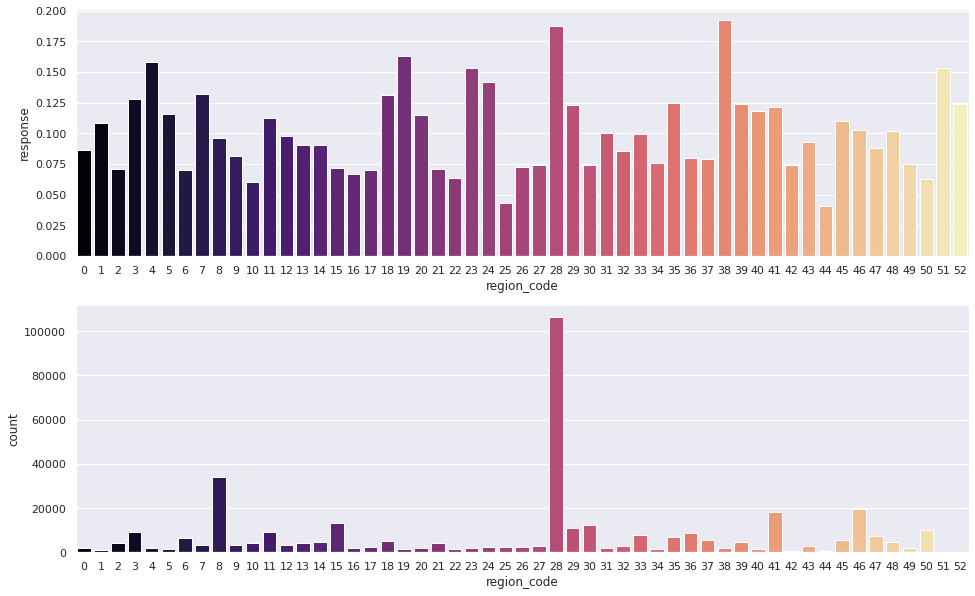

In [62]:
fig = plt.figure(figsize = (16,10))

plt.subplot (2,1,1)
aux1 = df4[['region_code', 'response']].groupby('region_code').mean().reset_index()
sns.barplot (x = 'region_code', y = 'response', data = aux1, palette = "magma");

plt.subplot (2,1,2)
sns.countplot(df4['region_code'], palette = "magma");

### H6: Customers that had previous acidents should want more a motor ensurance.
**TRUE.** Customers that had previous acidents want more a motor ensurance.

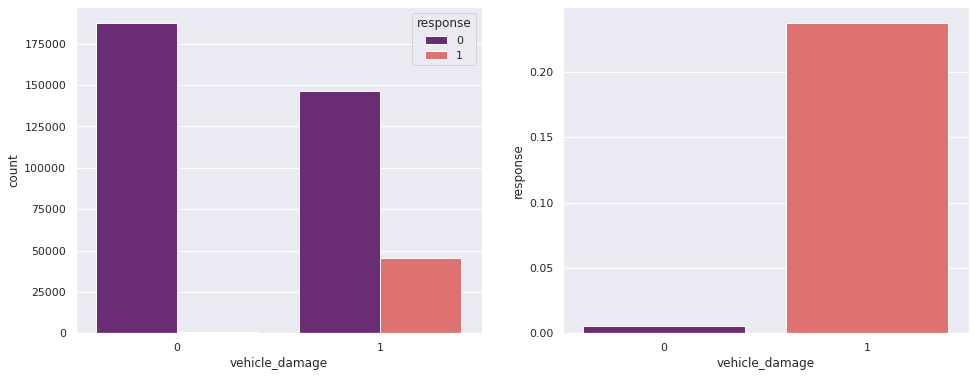

In [63]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
sns.countplot(x = df4['vehicle_damage'], hue = df4['response'], palette = "magma");

plt.subplot (1,2,2)
aux1 = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').mean().reset_index()
sns.barplot (x = 'vehicle_damage', y = 'response', data = aux1, palette = "magma");

### H7: Customers who own a newer cars should want more auto insurance.
**FALSE.** Customers who own a older cars should want more auto insurance.

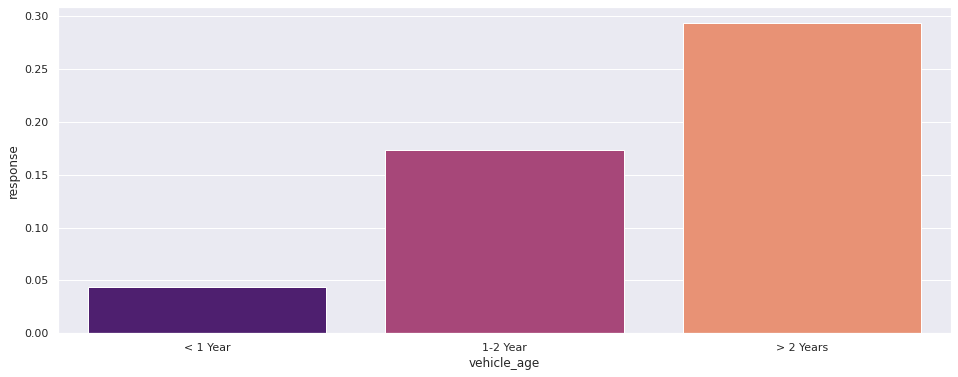

In [64]:
fig = plt.figure(figsize = (16,6))

aux1 = df4[['vehicle_age', 'response']].groupby('vehicle_age').mean().reset_index()
sns.barplot (x = 'vehicle_age', y = 'response', data = aux1, order = ['< 1 Year', '1-2 Year', '> 2 Years'], palette = "magma");

### H8: Customers that had a previous auto ensurance should want more a motor ensurance.
**FALSE.** Customers that had a previous auto ensurance don't want more a motor ensurance.

<AxesSubplot:xlabel='previously_insured', ylabel='response'>

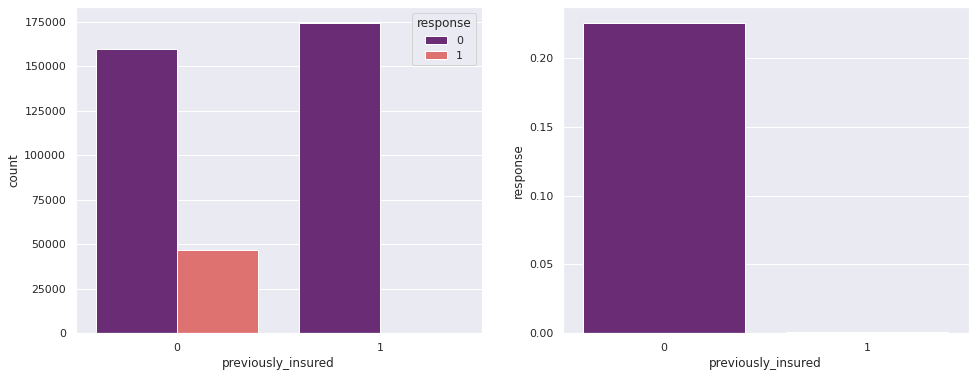

In [65]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
sns.countplot(x = df4['previously_insured'], hue = df4['response'], palette = "magma");

plt.subplot (1,2,2)
aux1 = df4[['previously_insured', 'response']].groupby('previously_insured').mean().reset_index()
sns.barplot (x = 'previously_insured', y = 'response', data = aux1, palette = "magma")

### H9: Customers who use life insurance more, should want auto insurance.
**FALSE.** There is no relationship between when the customer bought their health insurance and interest in car insurance.

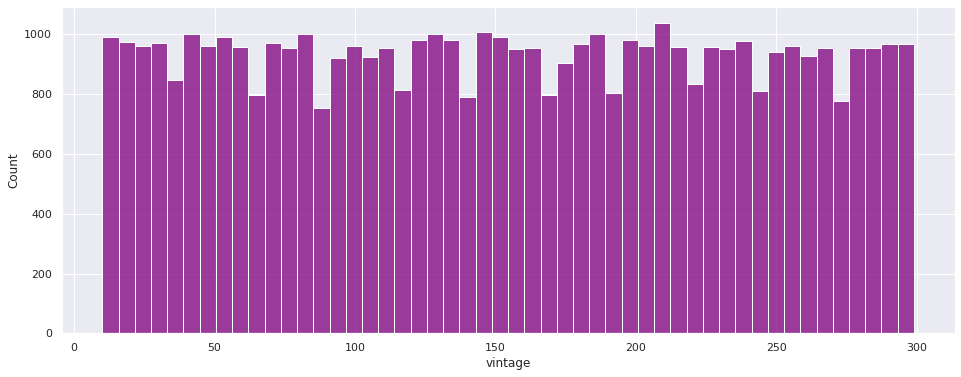

In [66]:
fig = plt.figure(figsize = (16,6))
sns.histplot(x = 'vintage', bins = 50, data = df4[df4['response'] == 1], color = 'purple');

### H10: Customers who live in regions with more demage rate should want auto insurance.
**TRUE.** Customers who live in regions with more demage rate should want auto insurance.

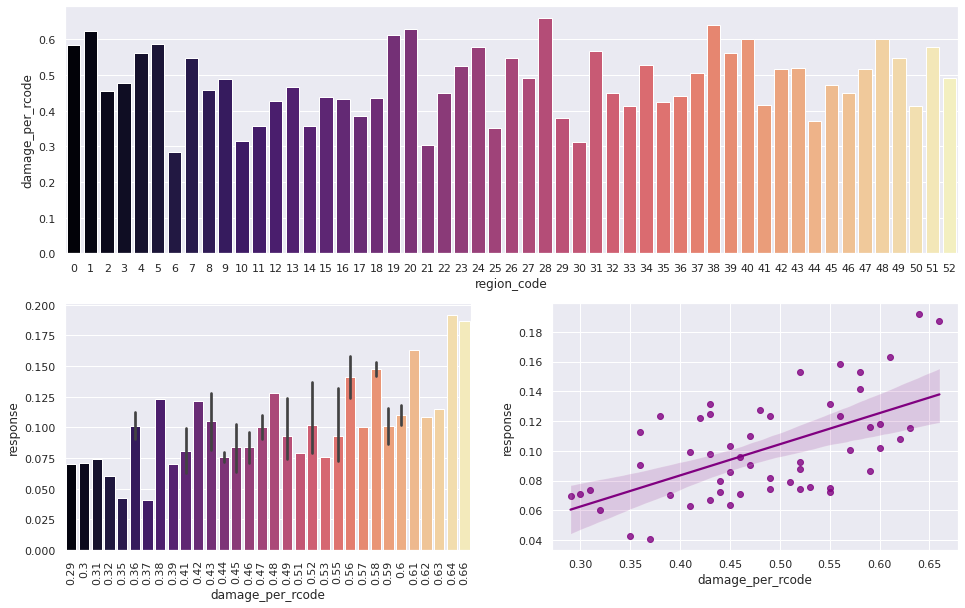

In [67]:
fig = plt.figure(figsize = (16,10))
grid = gridspec.GridSpec(2,2)

plt.subplot (grid[0,:])
aux1 = df4[['region_code', 'damage_per_rcode']].groupby('region_code').mean().reset_index()
sns.barplot(x = 'region_code', y = 'damage_per_rcode', data = aux1, palette = "magma");

plt.subplot (grid[1,0])
aux2 = df4[['damage_per_rcode', 'response']].groupby('damage_per_rcode').mean().reset_index()
aux2['damage_per_rcode'] = aux2['damage_per_rcode'].round(2)
sns.barplot (x = 'damage_per_rcode', y = 'response', data = aux2, palette = "magma");
plt.xticks(rotation = 90);

plt.subplot (grid[1,1])
sns.regplot(x = 'damage_per_rcode', y = 'response', data = aux2, color = 'purple');

### 4.2.1 Hypotheses resume

In [68]:
# display columns complete description
pd.set_option('display.max_colwidth', None)



# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['Older customers should want more a motor ensurance.',
                                      'Female customers should want more a motor ensurance.',
                                      'Customers without drive license should not want a motor ensurance.',
                                      'Customers with high Annual Premium should want more a motor ensurance.',
                                      'Customers that lives on city centers should want more a motor ensurance.',
                                      'Customers that had previous acidents should want more a motor ensurance.',
                                      'Customers who own a newer car should want more auto insurance.',
                                      'Customers that had a previous auto ensurance should want more a motor ensurance.',
                                      'Customers who use life insurance more, should want auto insurance.',
                                      'Customers who live in regions with more demage rate should want auto insurance.'],
                        'True / False':['False', 'False', 'True', 'True', 'True', 'True', 'False', 'False', 'False',
                                        'True'], 
                        'Relevance':['High', 'Low', 'High', 'High', 'Medium', 'High','High', 'Medium', 'Low', 'Medium']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
summary

,Hypothesis,True / False,Relevance
1,Older customers should want more a motor ensurance.,False,High
2,Female customers should want more a motor ensurance.,False,Low
3,Customers without drive license should not want a motor ensurance.,True,High
4,Customers with high Annual Premium should want more a motor ensurance.,True,High
5,Customers that lives on city centers should want more a motor ensurance.,True,Medium
6,Customers that had previous acidents should want more a motor ensurance.,True,High
7,Customers who own a newer car should want more auto insurance.,False,High
8,Customers that had a previous auto ensurance should want more a motor ensurance.,False,Medium
9,"Customers who use life insurance more, should want auto insurance.",False,Low
10,Customers who live in regions with more demage rate should want auto insurance.,True,Medium


## 4.3 Multivariate Analysis

In [69]:
# Divide features in numerical, categorical and binary
num_attributes = df4[['age','region_code', 'annual_premium', 'vintage']]
bin_attributes = df4[['driving_license', 'vehicle_damage', 'previously_insured', 'response']]
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 4.3.1 Numerical Attributes

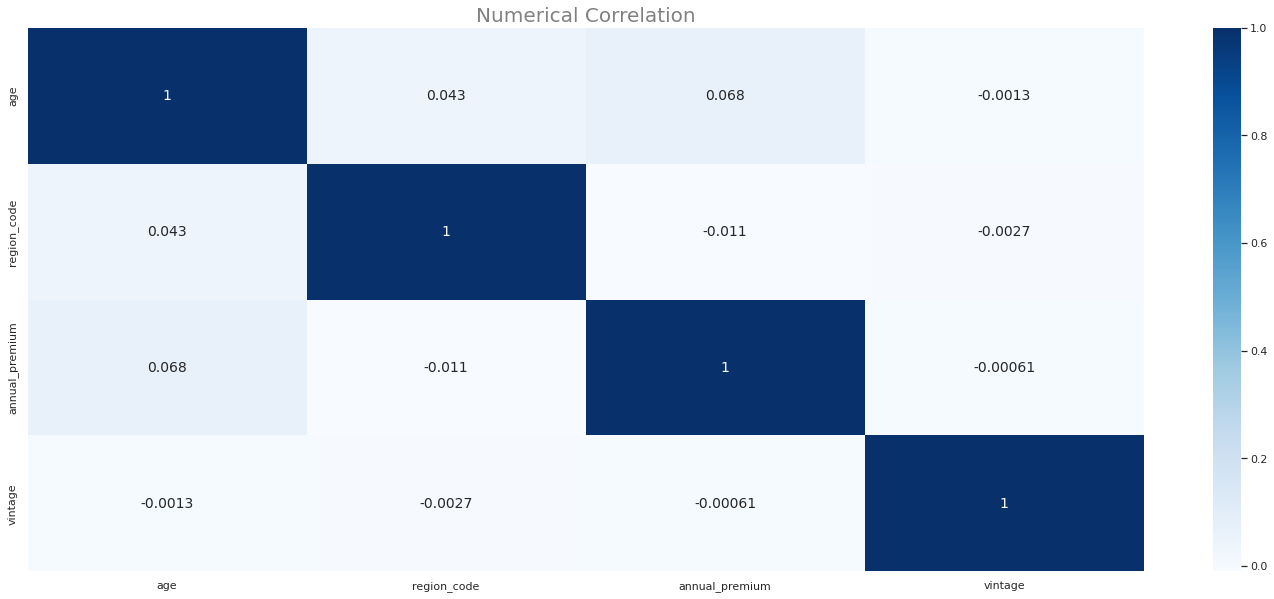

In [70]:
fig = plt.figure(figsize = (25,10))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Numerical Correlation", size=20, color='gray');

### 4.3.2 Binary x Numerical Attributes

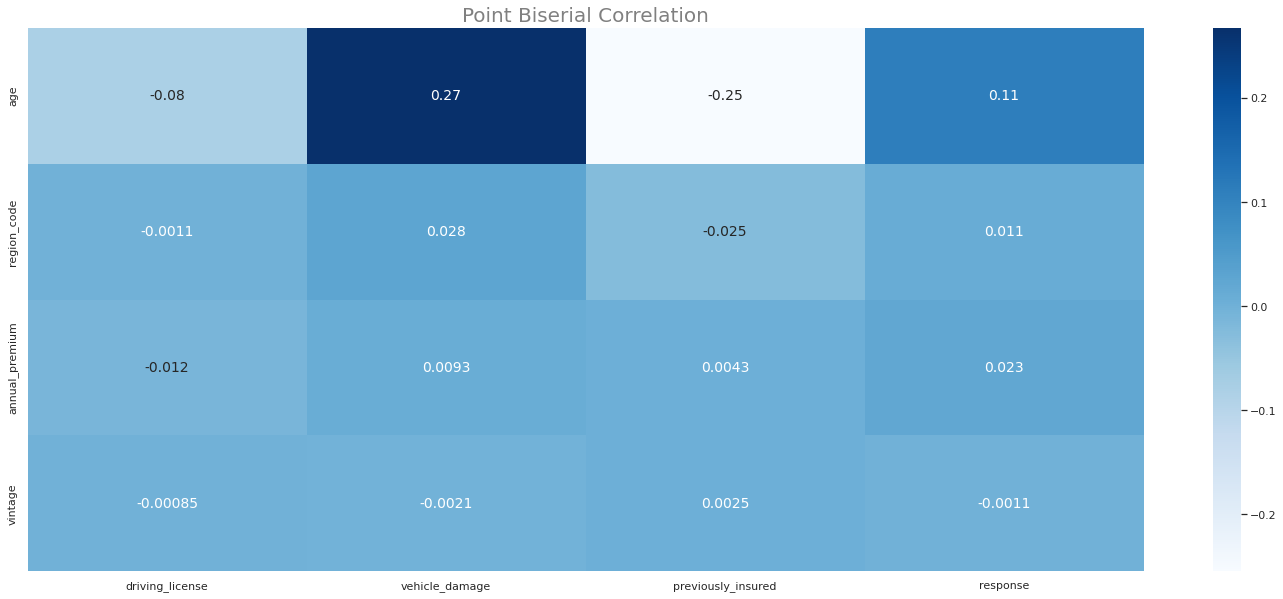

In [71]:
## Only numerical and binary data

# Calculate point bisserial correlation
x1 = pointbiserialr(bin_attributes['driving_license'], num_attributes['age'])[0]
x2 = pointbiserialr(bin_attributes['driving_license'], num_attributes['region_code'])[0]
x3 = pointbiserialr(bin_attributes['driving_license'], num_attributes['annual_premium'])[0]
x4 = pointbiserialr(bin_attributes['driving_license'], num_attributes['vintage'])[0]

x5 = pointbiserialr(bin_attributes['vehicle_damage'], num_attributes['age'])[0]
x6 = pointbiserialr(bin_attributes['vehicle_damage'], num_attributes['region_code'])[0]
x7 = pointbiserialr(bin_attributes['vehicle_damage'], num_attributes['annual_premium'])[0]
x8 = pointbiserialr(bin_attributes['vehicle_damage'], num_attributes['vintage'])[0]

x9 = pointbiserialr(bin_attributes['previously_insured'], num_attributes['age'])[0]
x10 = pointbiserialr(bin_attributes['previously_insured'], num_attributes['region_code'])[0]
x11 = pointbiserialr(bin_attributes['previously_insured'], num_attributes['annual_premium'])[0]
x12 = pointbiserialr(bin_attributes['previously_insured'], num_attributes['vintage'])[0]

x13 = pointbiserialr(bin_attributes['response'], num_attributes['age'])[0]
x14 = pointbiserialr(bin_attributes['response'], num_attributes['region_code'])[0]
x15 = pointbiserialr(bin_attributes['response'], num_attributes['annual_premium'])[0]
x16 = pointbiserialr(bin_attributes['response'], num_attributes['vintage'])[0]

# Final dataset
d = pd.DataFrame({'driving_license':[x1, x2, x3, x4],
                  'vehicle_damage':[x5, x6, x7,x8 ],
                  'previously_insured':[x9, x10, x11, x12],
                  'response': [x13, x14, x15, x16]})

# Sets the index equal to columns
d = d.set_index(num_attributes.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Point Biserial Correlation", size=20, color='gray');

### 4.3.3 Categorical Attributes

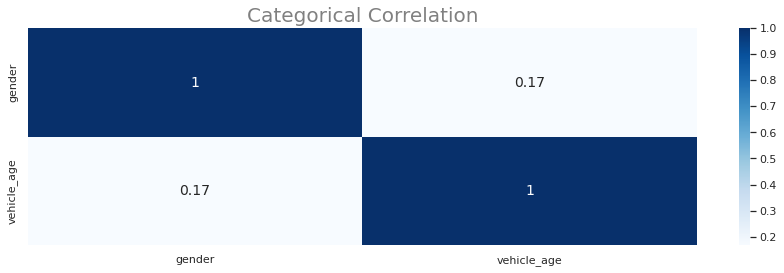

In [72]:
# Only categorical data
a = df4.select_dtypes( include = 'object')

# Calculate cramer v
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )

a3 = cramer_v( a['vehicle_age'], a['gender'] )
a4 = cramer_v( a['vehicle_age'], a['vehicle_age'] )


# Final dataset
d = pd.DataFrame( {'gender': [a1, a2],
                   'vehicle_age': [a3, a4],})

d = d.set_index(d.columns)

fig = plt.figure(figsize = (15,4))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Categorical Correlation", size=20, color='gray');

# 5.0 DATA PREPARATION

In [73]:
df5 = df4.copy()

In [74]:
X = df4.drop( 'response', axis = 1)
y = df4['response'].copy()

x_train, x_validation,y_train, y_validation = ms.train_test_split( X, y, test_size =0.20)

df5= pd.concat( [ x_train, y_train], axis= 1)

In [75]:
df5.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'driving_license',
       'vehicle_age', 'vehicle_damage', 'damage_per_rcode', 'response'],
      dtype='object')

In [76]:
num_attributes.columns

Index(['age', 'region_code', 'annual_premium', 'vintage'], dtype='object')

## 5.1 Standardization

In [77]:
ss = pp.StandardScaler()

# Annual Premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values)
pickle.dump( ss, open( '/home/leandro/repos/PA_04_Leandro/health_insurance_app/features/annual_premium_scaler.pkl', 'wb'))


## 5.2 Rescaling Features

In [78]:
# Necessário identificar cada 1 dos minmax 1 hora e 43

mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values)
pickle.dump(mms_age, open( '/home/leandro/repos/PA_04_Leandro/health_insurance_app/features/age_scaler.pkl', 'wb'))


# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values)
pickle.dump(mms_vintage, open( '/home/leandro/repos/PA_04_Leandro/health_insurance_app/features/vintage_scaler.pkl', 'wb'))


In [79]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,damage_per_rcode,response
152753,77749,Male,0.35385,28,124,0,0.80452,0.78201,1,1-2 Year,1,0.66002,0
321641,283859,Female,0.89231,41,124,1,-0.16514,0.42907,1,1-2 Year,0,0.41647,0
339290,45682,Male,0.04615,6,152,1,0.29044,0.09343,1,< 1 Year,0,0.28567,0
70517,182068,Female,0.07692,24,152,1,-0.15422,0.79239,1,< 1 Year,0,0.58012,0
45609,363887,Male,0.00000,46,160,1,0.44485,0.03114,1,< 1 Year,0,0.44858,0


## 5.3 Features Transformation

### 5.3.1 Encoding

In [80]:
df5.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'driving_license',
       'vehicle_age', 'vehicle_damage', 'damage_per_rcode', 'response'],
      dtype='object')

In [81]:
# One Hot Encoding / Frequency Encoding / Target Encoding

# Gender- One hot encoding / Target encoding
target_encode_gender = df5.groupby( 'gender')['response'].mean()
df5.loc[ :, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump(target_encode_gender, open( '/home/leandro/repos/PA_04_Leandro/health_insurance_app/features/target_encode_gender_scaler.pkl', 'wb' ))

# Region Code- One Hot Encoding / <span class="mark">Target Encoding</span> / Weighted Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean() 
df5.loc[ :, 'region_code'] = df5['region_code'].map ( target_encode_region_code)
pickle.dump( target_encode_region_code, open('/home/leandro/repos/PA_04_Leandro/health_insurance_app/features/target_encode_region_code_scaler.pkl', 'wb'))

# Vehicle Age- One hot encoding / Order encoding / Frequency Encoding 
df5 = pd.get_dummies( df5, prefix= 'vehicle_age', columns= ['vehicle_age' ] )

# Policy Sales Channel -Target Encoding / Frequency encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel').size()/len( df5 )
df5.loc[:, 'policy_sales_channel']= df5['policy_sales_channel'].map ( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '/home/leandro/repos/PA_04_Leandro/health_insurance_app/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

## 5.4 Validation Preparation

In [82]:
# gender
x_validation.loc[ :, 'gender'] = x_validation.loc[ :, 'gender'].map ( target_encode_gender)

# age
x_validation.loc[ :, 'age'] = mms_age.transform( x_validation[['age']].values)

# region_code
x_validation.loc[ :, 'region_code'] = x_validation.loc[ :, 'region_code'].map( target_encode_region_code)

# vehicle age
x_validation = pd.get_dummies( x_validation, prefix= 'vehicle_age', columns= ['vehicle_age'])

# annual premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values)

#fillna
x_validation = x_validation.fillna(0)
                                               


In [83]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_damage,damage_per_rcode,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
152753,77749,0.13870,0.35385,0.18729,0.19438,0,0.80452,0.78201,1,1,0.66002,0,1,0,0
321641,283859,0.10357,0.89231,0.12243,0.19438,1,-0.16514,0.42907,1,0,0.41647,0,1,0,0
339290,45682,0.13870,0.04615,0.06863,0.35433,1,0.29044,0.09343,1,0,0.28567,0,0,1,0
70517,182068,0.10357,0.07692,0.14426,0.35433,1,-0.15422,0.79239,1,0,0.58012,0,0,1,0
45609,363887,0.13870,0.00000,0.10197,0.05687,1,0.44485,0.03114,1,0,0.44858,0,0,1,0


# 6.0 FEATURE SELECTION

In [84]:
df6 = df5.copy()

### 6.2.2 Features importance

In [85]:
# model definition
forest= en.ExtraTreesClassifier( n_estimators= 250, random_state=0, n_jobs=-1)

# Data preparation
x_train_n= df6.drop(['response'], axis=1)
y_train_n= y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                 feature  importance
0                     id     0.19087
0                vintage     0.18579
0         annual_premium     0.16355
0                    age     0.15429
0         vehicle_damage     0.07252
0   policy_sales_channel     0.06202
0     previously_insured     0.05038
0            region_code     0.04591
0       damage_per_rcode     0.04339
0   vehicle_age_< 1 Year     0.01189
0   vehicle_age_1-2 Year     0.00822
0                 gender     0.00779
0  vehicle_age_> 2 Years     0.00286
0        driving_license     0.00052


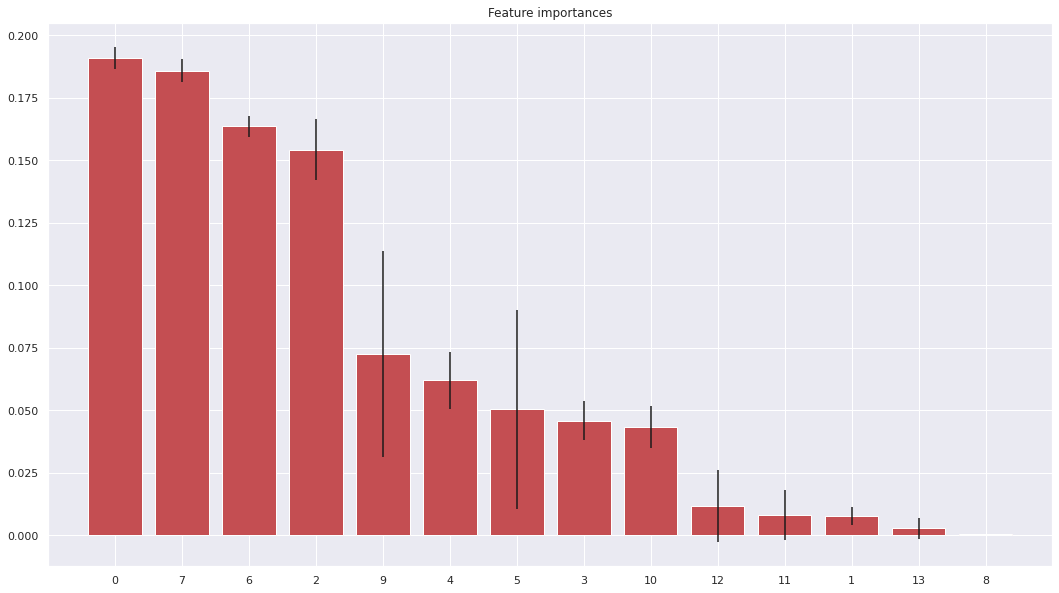

In [86]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort( importances)[::-1]

# Print the feature ranking
print( 'Feature ranking')
df = pd.DataFrame()
for i,j in zip( x_train_n, forest.feature_importances_):
    aux= pd.DataFrame( {'feature': i, 'importance':j}, index=[0])
    df = pd.concat( [df,aux], axis= 0)
    
    
print( df.sort_values('importance',ascending= False ) )

# Plot the impurity-base feature importances of the forest
plt.figure(figsize=(18,10))
plt.title( 'Feature importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color= 'r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 MACHINE LEARNING MODELLING

In [87]:
df7 = df6.copy()

In [88]:
df7.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_damage,damage_per_rcode,response,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
152753,77749,0.13870,0.35385,0.18729,0.19438,0,0.80452,0.78201,1,1,0.66002,0,1,0,0
321641,283859,0.10357,0.89231,0.12243,0.19438,1,-0.16514,0.42907,1,0,0.41647,0,1,0,0
339290,45682,0.13870,0.04615,0.06863,0.35433,1,0.29044,0.09343,1,0,0.28567,0,0,1,0
70517,182068,0.10357,0.07692,0.14426,0.35433,1,-0.15422,0.79239,1,0,0.58012,0,0,1,0
45609,363887,0.13870,0.00000,0.10197,0.05687,1,0.44485,0.03114,1,0,0.44858,0,0,1,0


In [89]:
cols_selected= ['vintage',
                'annual_premium',
                'age',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured',
                'region_code']

x_train = df7[ cols_selected]
x_val = x_validation[ cols_selected]




## 7.1 KNN

In [90]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors= 5)

# model training
knn_model.fit( x_train, y_train)

# model Prediciton - Poder de Generalização
yhat_knn = knn_model.predict_proba( x_val)

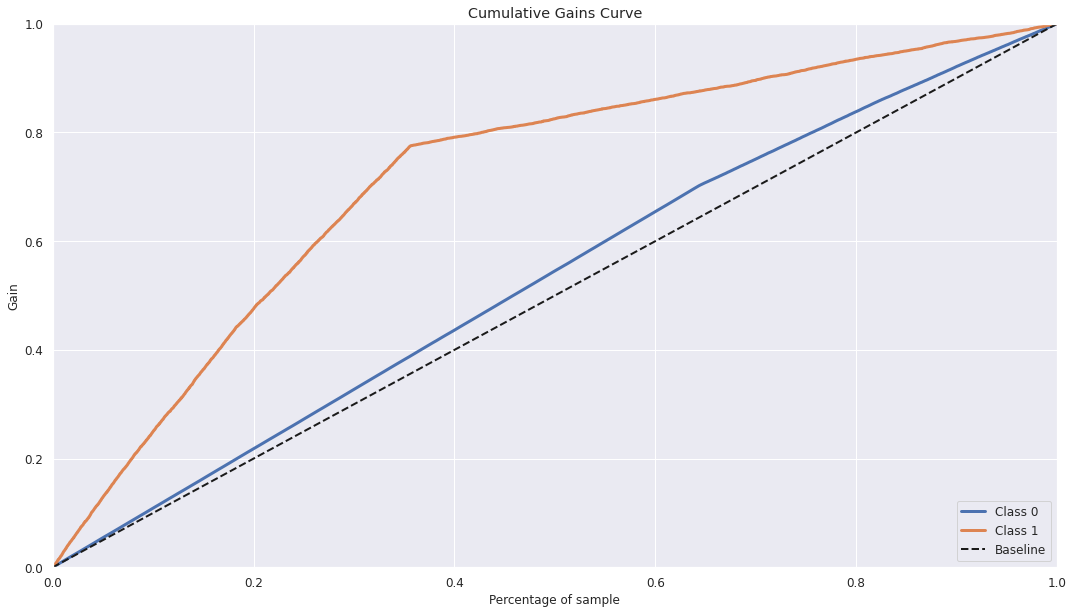

In [91]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn,figsize=(18,10));

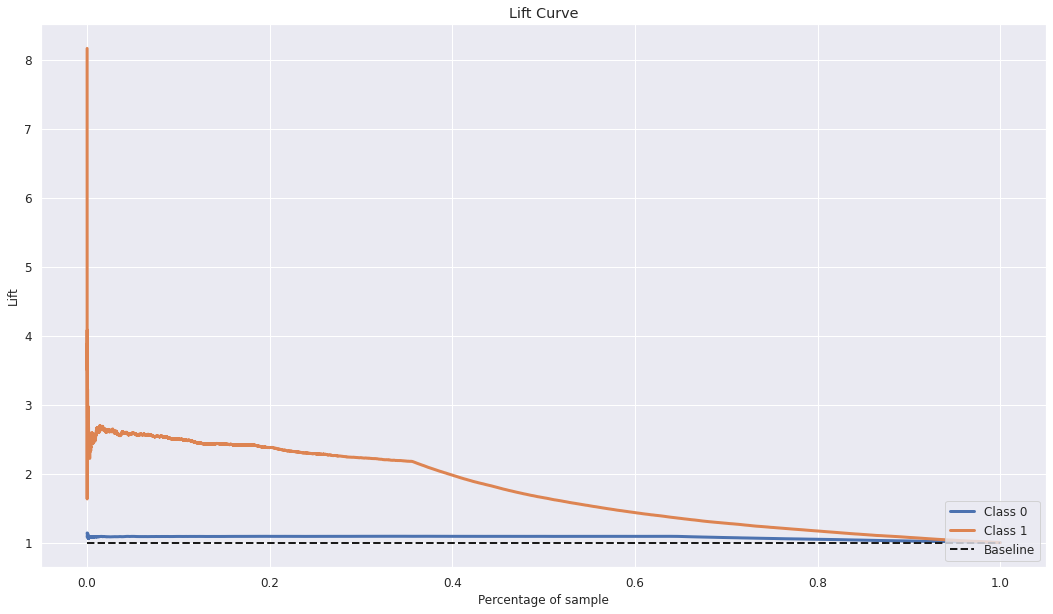

In [92]:
# Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_knn,figsize=(18,10));

# 7.2 Logistic Regression

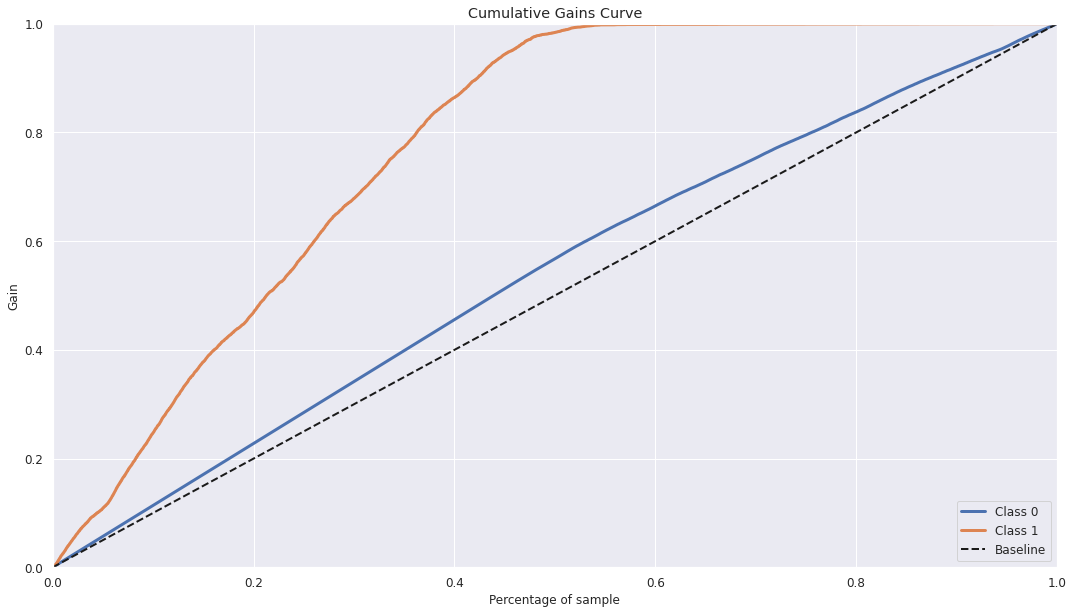

In [188]:
# model definitio
lr_model = lm.LogisticRegression( random_state= 42)

# model training
lr_model.fit( x_train, y_train)

#model Prediction
yhat_lr= lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr,figsize=(18,10));

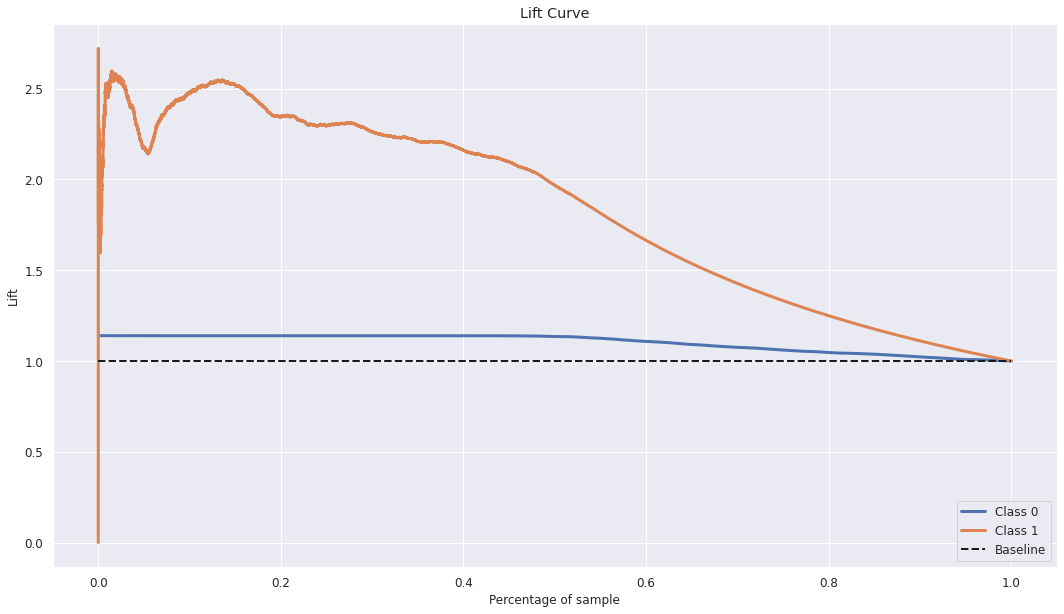

In [94]:
# Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_lr,figsize=(18,10));

## 7.3 Extra Trees

In [95]:
## Model definition
et = en.ExtraTreesClassifier( n_estimators= 500, n_jobs= -1, random_state= 42 )


## Model fit
et.fit( x_train, y_train )

## Model Predict
yhat_et =  et.predict_proba( x_val )

In [96]:
## Model Predict
yhat_et =  et.predict_proba( x_val )

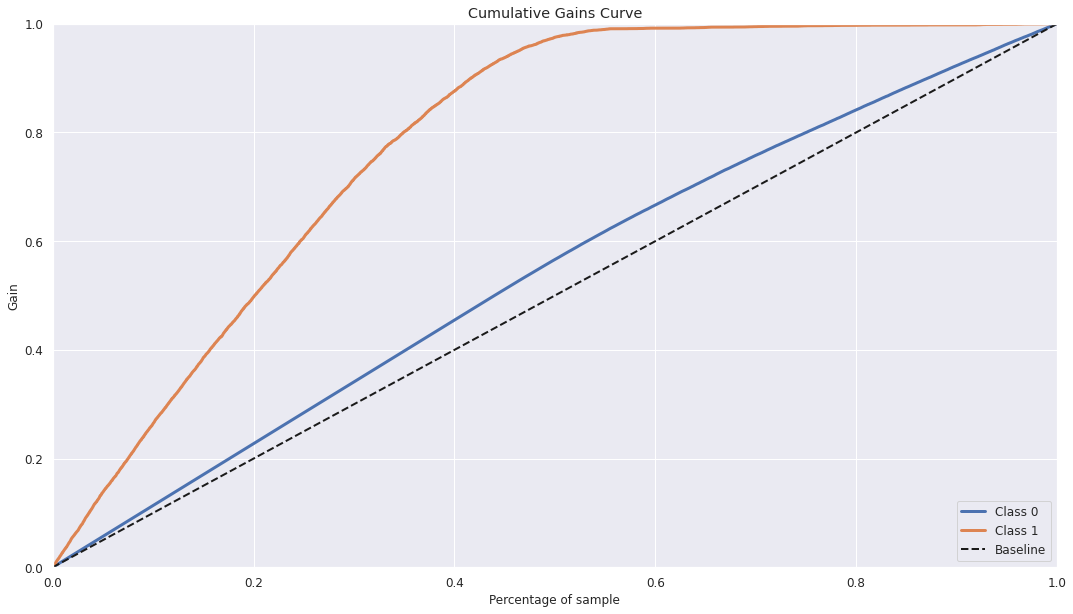

In [97]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_et,figsize=(18,10));

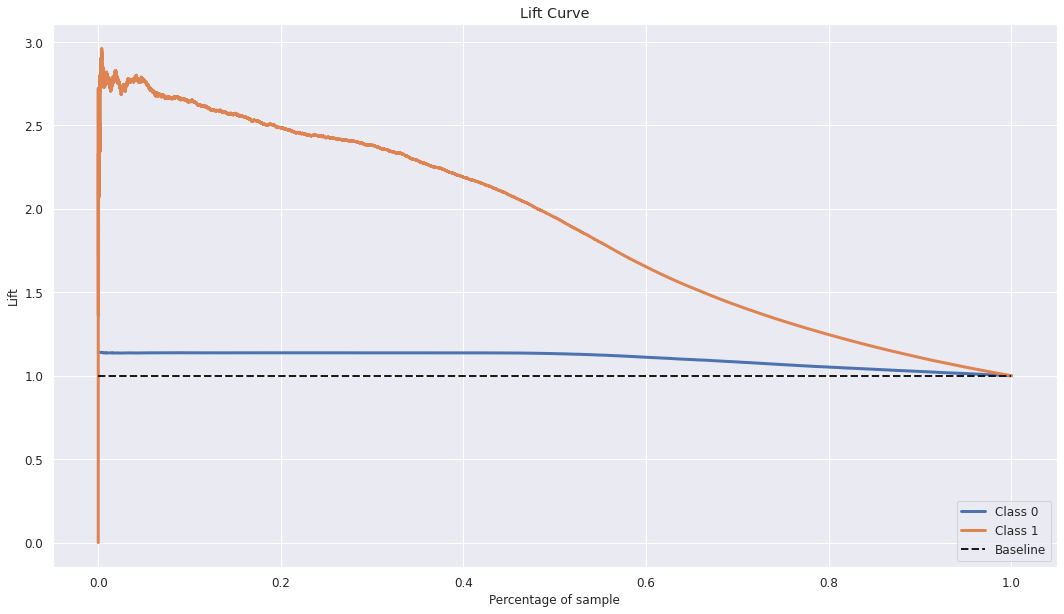

In [98]:
# Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_et,figsize=(18,10));

# 7.4 Random Forest

In [99]:
## Model Definition
rf = en.RandomForestClassifier( n_estimators= 250, n_jobs= -1, random_state= 42)

## Model training
rf.fit( x_train, y_train )

## Model Prediction
yhat_rf = et.predict_proba( x_val)

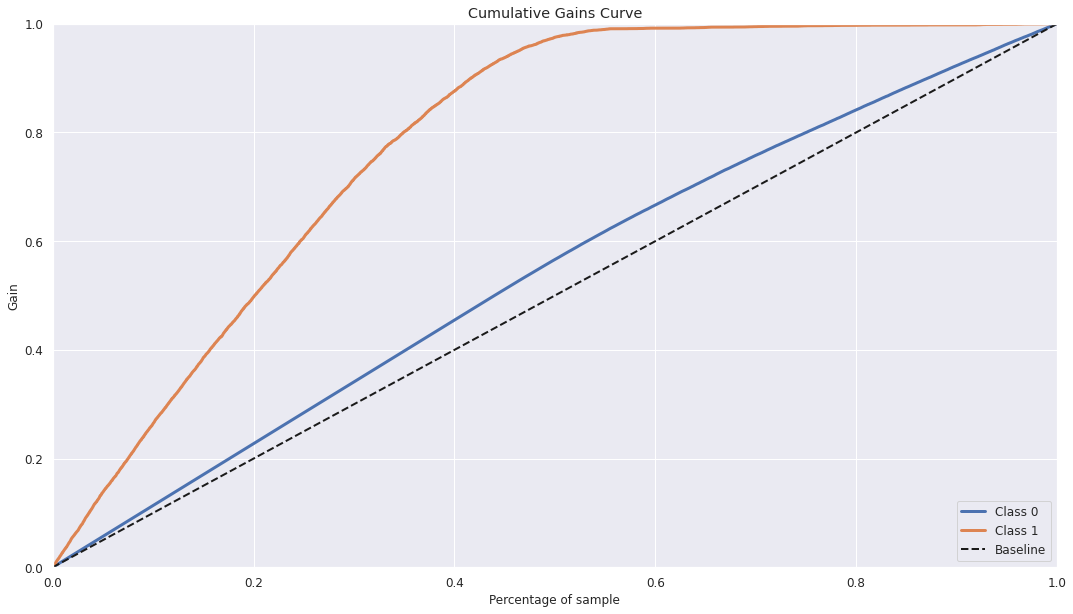

In [100]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_rf,figsize=(18,10));

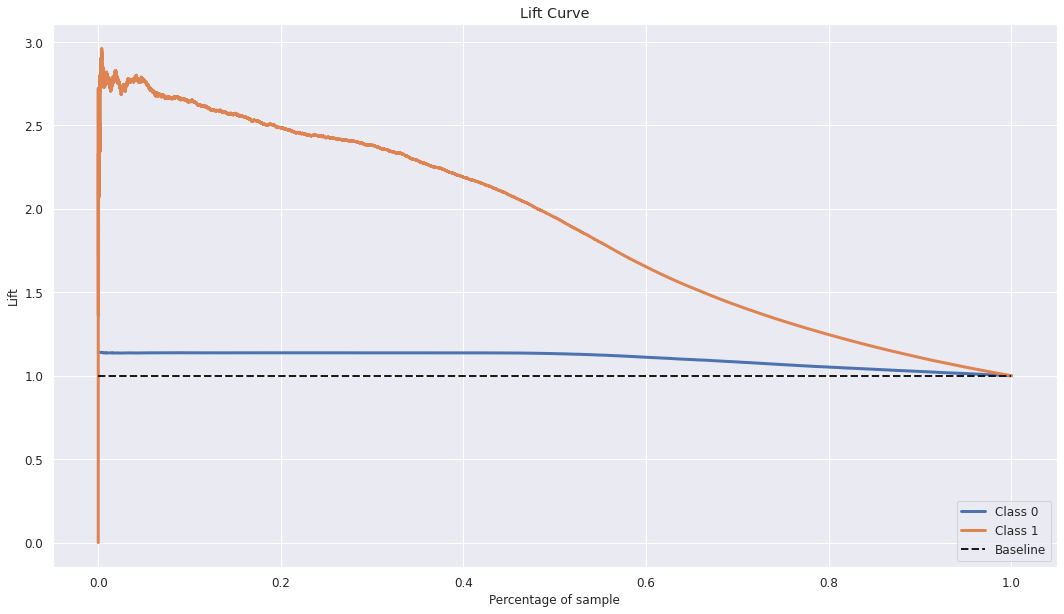

In [101]:
# Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_rf,figsize=(18,10));

## 7.5 Cross Validation

In [173]:
def cross_validation(models, X, y, cv,n_jobs= -1):
    cv_df = []
    for n in models:
        accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
        accuracy = "{:.4f} +/- %{:.4f}".format(accuracy_cv.mean(), accuracy_cv.std())
        prec_cv = cross_val_score(n, X, y, cv = cv, scoring='precision', n_jobs=-1)
        prec = "{:.4f} +/- %{:.4f}".format(prec_cv.mean(), prec_cv.std())
        recall_cv = cross_val_score(n, X, y, cv = cv, scoring='recall', n_jobs=-1)
        recall = "{:.4f} +/- %{:.4f}".format(recall_cv.mean(), recall_cv.std())
        f1_score_cv = cross_val_score(n, X, y, cv = cv, scoring='f1', n_jobs=-1)
        f1_score = "{:.4f} +/- %{:.4f}".format(f1_score_cv.mean(), f1_score_cv.std())
        roc_auc_cv = cross_val_score(n, X, y, cv = cv, scoring='roc_auc', n_jobs=-1)
        roc_auc = "{:.4f} +/- %{:.4f}".format(roc_auc_cv.mean(), roc_auc_cv.std())
        
                
        A = pd.DataFrame( {'Model Name': type(n).__name__,
                           'Accuracy (Avg+Std)': accuracy,
                           'Precision (Avg+Std) ': prec,
                           'Recall (Avg+Std) ': recall,
                           'F1-Score (Avg+Std)': f1_score,
                           'ROC-AUC (Avg+Std)': roc_auc }, index = [0])
    
        cv_df.append(A)
        final_dfa = pd.concat(cv_df)

    return final_dfa

In [174]:
knn_model = nh.KNeighborsClassifier(n_neighbors=8, weights='distance')
lr_model  = lm.LogisticRegression(random_state = 42)
rf_model  = RandomForestClassifier(n_estimators= 250, random_state=42)

models= [knn_model,lr_model,rf_model]

In [175]:
cross_validation(models,x_validation,y_validation,cv=5)

,Model Name,Accuracy (Avg+Std),Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std)
0,KNeighborsClassifier,0.8596 +/- %0.0011,0.1733 +/- %0.0076,0.0387 +/- %0.0019,0.0632 +/- %0.0028,0.5055 +/- %0.0092
0,LogisticRegression,0.8775 +/- %0.0000,0.0000 +/- %0.0000,0.0000 +/- %0.0000,0.0000 +/- %0.0000,0.5002 +/- %0.0094
0,RandomForestClassifier,1.0000 +/- %0.0000,1.0000 +/- %0.0000,1.0000 +/- %0.0000,1.0000 +/- %0.0000,1.0000 +/- %0.0000


/home/leandro/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedM

## 7.6 Lr model fine tuning 

In [190]:

# example of grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param));

Best: 0.967667 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.959667 (0.015162) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.959333 (0.013646) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.959667 (0.014020) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.960000 (0.016533) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.961000 (0.013503) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.960000 (0.014142) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.962333 (0.017829) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.960667 (0.015261) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.960333 (0.013780) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.963000 (0.016961) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.963333 (0.016997) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.963333 (0.014220) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.967667 (0.014985) wi

# 8.0 Model Performance

In [102]:
# Copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# Propensity score
df8['score'] = yhat_knn[:,1].tolist()

# sorted clients by propensity score
df8 = df8.sort_values( 'score', ascending= False)


    
# Compute precison at K
precision_at_50 = precision_at_k(df8,k=50)
print('Precision at K: {}'.format( precision_at_50 ) )

# Compute recall at K
recall_at_50 = recall_at_k(df8,k=50)
print( 'Recall at K:{} '.format( recall_at_50))

Precision at K: 0.23529411764705882
Recall at K:0.0012854847348687734 


In [103]:
# reset index
df8 = df8.reset_index( drop= True)

# Create Ranking order
df8['ranking'] = df8.index+1

df8['precision_at_k'] = df8['response'].cumsum()/ df8['ranking']

df8[['id', 'response', 'score','ranking','precision_at_k']].reset_index(drop= True).head()

,id,response,score,ranking,precision_at_k
0,37261,0,1.00000,1,0.00000
1,274510,1,1.00000,2,0.50000
2,89991,0,1.00000,3,0.33333
3,293729,0,1.00000,4,0.25000
4,239349,1,1.00000,5,0.40000


# 9.0 Final Model

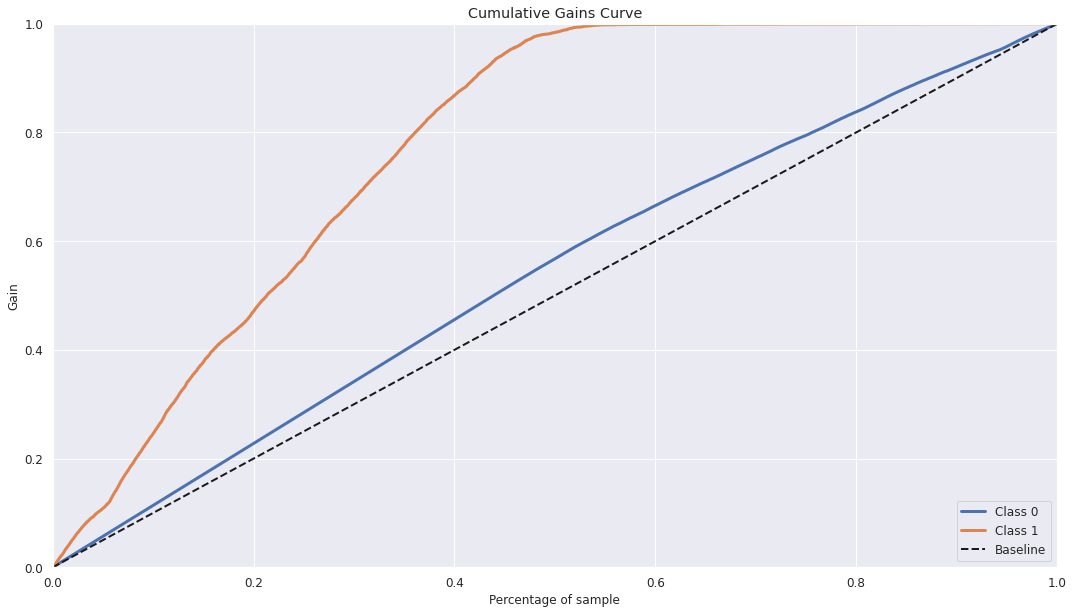

In [191]:
# model definitio
lr_model = lm.LogisticRegression( random_state= 42,C= 0.1, penalty='l2', solver =  'newton-cg')

# model training
lr_model.fit( x_train, y_train)

#model Prediction
yhat_lr= lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr,figsize=(18,10));

# Save training model
pickle.dump( lr_model, open('/home/leandro/repos/PA_04_Leandro/model_linear_regression.pkl', 'wb' ) )

# 10.0 Deploy to production

# 10.1 Health Insurance Class

In [105]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance( object ):
    
    def __init__( self ):
        self.home_path = '/home/leandro/repos/PA_04_Leandro/health_insurance_app/features/'
        self.annual_premium_scaler = pickle.load(open (self.home_path + 'annual_premium_scaler.pkl','rb'))
        self.age_scaler = pickle.load(open(self.home_path + 'age_scaler.pkl','rb'))
        self.vintage_scaler = pickle.load(open (self.home_path + 'vintage_scaler.pkl', 'rb'))
        self.target_encode_gender_scaler = pickle.load(open ( self.home_path + 'target_encode_gender_scaler.pkl','rb'))
        self.target_encode_region_code_scaler = pickle.load(open( self.home_path + 'target_encode_region_code_scaler.pkl','rb'))
        self.fe_policy_sales_channel_scaler = pickle.load(open(self.home_path + 'fe_policy_sales_channel_scaler.pkl','rb'))
    
    def data_cleaning(self, df1 ):
        col_names = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
                     'previously_insured', 'annual_premium', 'vintage', 'driving_license',
                     'vehicle_damage', 'damage_per_rcode', 'vehicle_age_1-2 Year',
                     'vehicle_age_< 1 Year', 'vehicle_age_> 2 Years', 'response']
        
        df1.columns = col_names
        return df1


        
       
    
    def feature_engeneering(self, df2 ):
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=="Yes" else 0)
        #df2['vehicle_age']    = df2['vehicle_age'].apply(lambda x: "over_2years" if x =="> 2 Years" else "between_12years" if x == "1-2 Year" else "below_year")
        #df2['gender']         = df2['gender'].apply(lambda x: x.lower())
        
        return df2
  

    
    def data_preparation( self,df5):
        # Annual Premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values)

        # Age
        df5['age'] = self.age_scaler.transform( df5[['age']].values)
        
        # Vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values)
        
        ## 5.3 Features Transformation1
    
        df5.loc[ :, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )
        
        # Region Code- One Hot Encoding / <span class="mark">Target Encoding</span> / Weighted Target Encoding
        #df5.loc[ :, 'region_code'] = df5['region_code'].map ( self.target_encode_region_code_scaler)
       
        # Vehicle Age- One hot encoding / Order encoding / Frequency Encoding 
        df5 = pd.get_dummies( df5, prefix= 'vehicle_age', columns= ['vehicle_age_1-2 Year' ] )
        df5 = pd.get_dummies( df5, prefix= 'vehicle_age', columns= ['vehicle_age_< 1 Year' ] )
        df5 = pd.get_dummies( df5, prefix= 'vehicle_age', columns= ['vehicle_age_> 2 Years' ] )

        # Policy Sales Channel -Target Encoding / Frequency encoding
        #df5.loc[:, 'policy_sales_channel']= df5['policy_sales_channel'].map ( self.fe_policy_sales_channel_scaler )

        df5.fillna(0,inplace = True)

        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]



    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred[:,1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

# 10.2 API Handler

In [106]:
# import os
# import pickle
# import pandas as pd
# import numpy  as np
# from flask import Flask, request, Response
# from healthinsurance.HealthInsurance import HealthInsurance


# print('Loading predictor model...')
# path  = '/home/leandro/repos/PA_04_Leandro/health_insurance_app/models/'
# model = pickle.load(open(path + 'model_linear_regression.pkl','rb'))
# print('Loaded!')


# print("\n========= INITIALIZING SERVER ==========\n\n")

# #initialize api
# app = Flask(__name__)

# @app.route('/predict', methods=['POST'])
# def healthinsurance_predict():
#     test_json = request.get_json()
    
#     if test_json:
#         if isinstance(test_json,dict): #unique example
#             test_raw = pd.DataFrame(test_json,index=[0])
#         else: #multiple examples
#             test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
#         #instantiate HealthInsurance class
#         pipeline = HealthInsurance()

#         #data cleaning
#         df1 = pipeline.data_cleaning(test_raw)
#         print(df1)
        
#         #feature Engeneering
#         df2 = pipeline.feature_engeneering(df1)
#         print(df2)
        
#         #data preparation
#         df3 = pipeline.data_preparation(df2)
#         print(df3)
        
#         #prediction
#         df_response = pipeline.get_prediction(model,test_raw ,df3)
        
#         return df_response
#     else:
#         return Response('{}',status=200, mimetype='application/json')
    

# if __name__ =='__main__':
    
#     port = os.environ.get('PORT',5000)
#     app.run('0.0.0.0',port=port)
#     #



Loading predictor model...
Loaded!

========= INITIALIZING SERVER ==========


 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.1.111:5000/ (Press CTRL+C to quit)


## 10.3 API Tester

In [107]:
import requests

In [108]:
# loading teste dataset
df_test = x_validation
df_test['response'] = y_validation

In [109]:
# loading teste dataset
df_test = df_test.sample(200)

In [110]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']

In [111]:
import json

In [112]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient= 'records'))

In [113]:
data

'[{"id": 240385, "gender": 0.13870271842542206, "age": 0.46153846153846156, "region_code": 0.10052304674730304, "policy_sales_channel": 0.02778406425987333, "previously_insured": 0, "annual_premium": -1.622854936680104, "vintage": 0.07958477508650519, "driving_license": 1, "vehicle_damage": 1, "damage_per_rcode": 0.41468513195714657, "vehicle_age_1-2 Year": 1, "vehicle_age_< 1 Year": 0, "vehicle_age_> 2 Years": 0, "response": 0}, {"id": 105397, "gender": 0.13870271842542206, "age": 0.13846153846153847, "region_code": 0.07327278293703439, "policy_sales_channel": 0.20897906437466995, "previously_insured": 0, "annual_premium": -0.24879848634049911, "vintage": 0.7647058823529412, "driving_license": 1, "vehicle_damage": 1, "damage_per_rcode": 0.3132638831925191, "vehicle_age_1-2 Year": 1, "vehicle_age_< 1 Year": 0, "vehicle_age_> 2 Years": 0, "response": 1}, {"id": 26196, "gender": 0.13870271842542206, "age": 0.27692307692307694, "region_code": 0.1872948650079407, "policy_sales_channel": 0.

In [ ]:
# API Call

url = 'http://0.0.0.0:5000/predict'


header = {'Content-type': 'application/json'}

data = data

r = requests.post ( url, data= data, headers= header)
print('Status Code{}'.format( r.status_code))

In [ ]:
d1 = pd.DataFrame( r.json(), columns= r.json()[0].keys() )
d1.sort_values( 'prediction', ascending = False ).sample(30)